**Identifying overperforming schools**

by Ben Lacar
<br>
Updated August 2019

As an exercise in performing wrangling, data exploration, and data visualization, I chose to look at publicly available datasets of California public schools and census information. While exploring, I sought to identify overperforming school populations. I define this as a school's population that faces socio-economic difficulties yet have low dropout rates.

After talking with Morgan, plan is to start small and simple, then add complexity.



The data sources are at the level of granularity of zip code.

Similar applications of demographics towards predicting health outcomes has been performed by [Luo et al., 2015](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0125602). The Luo et al. study helped serve as a reference for analyses done here.

Project updates:

- August 2017: Performed data munging and visualizations as an exercise following Python courses.

- March 2018: First posting to website.

- April 2018: Received project feedback and began re-writing code to improve readability and code robustness.

- May 2018: Expanded project to include more demographic features other than just local median income and percentage of families below the poverty line. Develop a greater understanding of features by applying linear regression.

- June 2018: Continued improvements to code robustness.

- September 2019:

Used GreatSchools data. Find features that predict good low income ratings.




In [44]:
# Import packages

# Web scraping
import os
import urllib.request
import requests
from io import StringIO
from bs4 import BeautifulSoup
# Use xml package for GreatSchools data
import xml.etree.ElementTree as ET

# Dataframe munging and statistics
import re
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Data visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

# Machine learning
from sklearn.decomposition import PCA

# Machine learning, linear regression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
parent_path = '/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study/'
os.chdir(parent_path) 
os.getcwd()

'/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study'

## Data sources
1. Demographic information for CA by zip code (median income, employment status, worker class, education level)
2. School information (public, charter status, magnet status, address)
3. School enrollment and dropout data (by grades for ethnicity, gender)

### Data source 1: Population data by zip code (factfinder.census.gov)

#### Import and overview of census data

In [3]:
df_demo_info = pd.read_csv('data/ACS_15_5YR_DP03_with_ann.csv')
df_demo_info.head()

,Id,Id2,Geography,Estimate; EMPLOYMENT STATUS - Population 16 years and over,Margin of Error; EMPLOYMENT STATUS - Population 16 years and over,Percent; EMPLOYMENT STATUS - Population 16 years and over,Percent Margin of Error; EMPLOYMENT STATUS - Population 16 years and over,Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force,Margin of Error; EMPLOYMENT STATUS - Population 16 years and over - In labor force,Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force,...,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over
0,8600000US89010,89010,ZCTA5 89010,484,125,484,(X),233,92,48.1,...,19.7,17.5,(X),(X),21.2,16.2,(X),(X),39.1,23.2
1,8600000US89019,89019,ZCTA5 89019,1663,527,1663,(X),852,310,51.2,...,10.1,15,(X),(X),0,2.2,(X),(X),24.9,16.8
2,8600000US89046,89046,ZCTA5 89046,404,136,404,(X),175,96,43.3,...,10.9,13.4,(X),(X),41,34,(X),(X),40.1,20.6
3,8600000US89060,89060,ZCTA5 89060,8136,629,8136,(X),3473,514,42.7,...,10.7,5.1,(X),(X),18.5,6.9,(X),(X),23.9,6.2
4,8600000US89061,89061,ZCTA5 89061,4492,529,4492,(X),1889,340,42.1,...,2.5,3,(X),(X),3.2,3,(X),(X),18.2,11.8


In [4]:
df_demo_info.head()

,Id,Id2,Geography,Estimate; EMPLOYMENT STATUS - Population 16 years and over,Margin of Error; EMPLOYMENT STATUS - Population 16 years and over,Percent; EMPLOYMENT STATUS - Population 16 years and over,Percent Margin of Error; EMPLOYMENT STATUS - Population 16 years and over,Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force,Margin of Error; EMPLOYMENT STATUS - Population 16 years and over - In labor force,Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force,...,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over
0,8600000US89010,89010,ZCTA5 89010,484,125,484,(X),233,92,48.1,...,19.7,17.5,(X),(X),21.2,16.2,(X),(X),39.1,23.2
1,8600000US89019,89019,ZCTA5 89019,1663,527,1663,(X),852,310,51.2,...,10.1,15,(X),(X),0,2.2,(X),(X),24.9,16.8
2,8600000US89046,89046,ZCTA5 89046,404,136,404,(X),175,96,43.3,...,10.9,13.4,(X),(X),41,34,(X),(X),40.1,20.6
3,8600000US89060,89060,ZCTA5 89060,8136,629,8136,(X),3473,514,42.7,...,10.7,5.1,(X),(X),18.5,6.9,(X),(X),23.9,6.2
4,8600000US89061,89061,ZCTA5 89061,4492,529,4492,(X),1889,340,42.1,...,2.5,3,(X),(X),3.2,3,(X),(X),18.2,11.8


In [5]:
for i in df_demo_info['Id2'].unique():
    df_temp = df_demo_info[df_demo_info['Id2']==i]
    if df_temp.shape[0] > 1:
        df_temp
        break

In [6]:
len(df_demo_info['Id2'].unique())

1770

In [7]:
def import_census_data(csv_file):
    df_demo_info = pd.read_csv('data/ACS_15_5YR_DP03_with_ann.csv')
    df_demo_info.set_index('Id2', inplace=True) # set the zip code as the index value
    
    # Rename demographic information columns to improve readability
    demo_column_names = ({'Estimate': 'Est.',
                      'Percent': '%',
                      'EMPLOYMENT STATUS': 'EMPLOY_STATUS',
                      'Population': 'Pop.',
                      'Margin of Error': 'error_margin',
                      'and over': 'and up',
                      'years':'yrs',
                      'COMMUTING TO WORK': 'WORK_COMMUTE',
                      'CLASS OF WORKER': 'WORKER_CLASS',
                      'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)': 'INCOME_BENEFITS',
                      'HEALTH INSURANCE COVERAGE': 'HEALTH_INS_COVERAGE',
                      '(dollars)': '($)',
                      'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL': '%-AGE_FAMILIES_INCOME_BELOW_POVERTY',
                      '18 to 64': '18-64',
                      'with': 'w/',
                      'With': 'w/',
                      'under 18': '<18',
                      'population': 'pop.',
                      'health insurance coverage': 'health ins coverage'
                     })

    # Replace words in column names
    df_temp = pd.DataFrame()
    df_temp['old_col_names'] = df_demo_info.columns
    df_temp['new_col_names'] = None
    
    for i in range(len(df_temp)):
        string = df_temp.loc[i,'old_col_names']
        for key in demo_column_names:
            string = string.replace(key, demo_column_names[key])
        df_temp.loc[i, 'new_col_names'] = string
    df_demo_info.columns = df_temp['new_col_names']

    # Remove columns that contain "error" since it won't be used in the analysis moving forward.
    mask_col_w_error = df_demo_info.columns.str.contains('error')
    df_demo_info = df_demo_info.copy().loc[:,~mask_col_w_error]

    # Remove columns where most values are (X) 
    mask_of_X = df_demo_info.iloc[:,274]!='(X)'

    mask_of_X = df_demo_info !='(X)'
    samples_w_values = np.sum(mask_of_X)
    mask_columns_samples_wvalues = np.sum(mask_of_X) > 1400

    # Demographic info with values, no errors
    df_demo_info = df_demo_info.copy().loc[:,mask_columns_samples_wvalues]
    
    # Focus on features shown in percentages (other code were things I tried)
    mask_perc = df_demo_info.columns.str.startswith('%')
    #mask_est = df_test.columns.str.startswith('Est.')
    # df_test_only_numbers = df_test.loc[:, (mask_perc + mask_est)].copy()

    # Convert all strings with a dash into NaN
    df_demo_perc_only = df_demo_info.loc[:, mask_perc].copy()

    # Convert all strings with a dash into NaN
    mask_dash = (df_demo_perc_only=='-')  
    mask_x = (df_demo_perc_only=='(X)') 
    df_demo_perc_only[mask_dash | mask_x] = np.nan

    # Convert rest of values from string to floating point
    df_demo_perc_only = df_demo_perc_only.astype('float64', copy=False)
    
    # Identify features where most (90%) of the values are < 100%
    df_temp = pd.DataFrame()
    df_temp['feature'] = None
    df_temp['min'] = None
    df_temp['max'] = None
    df_temp['prop_<100%'] = None

    # Check range of values and determine the proportion less than 100%
    for index, value in enumerate(df_demo_perc_only.columns):
        try:
            df_temp.loc[index, 'feature'] = value
            df_temp.loc[index, ['min', 'max']] = (df_demo_perc_only[value].min(), df_demo_perc_only[value].max())
            # For next line, NaNs are not counted
            df_temp.loc[index, 'prop_<100%'] = sum(df_demo_perc_only[value] <= 100)/len(df_demo_perc_only)
        except:
            continue

    # Get features where most (90%) of the values are < 1 (100%)
    valid_features = df_temp.loc[df_temp['prop_<100%'] >= 0.9, 'feature'].tolist()
    
    # Add the identifying columns back in
    df_demo_info_perc = pd.merge(df_demo_info[['Id', 'Geography']], df_demo_perc_only[valid_features],
                                  left_index=True, right_index=True)
    
    # Remove rows where 90% of the census info for that zip code is missing
    df_demo_info_final = df_demo_info_perc[df_demo_info_perc.count(axis=1)/df_demo_info_perc.shape[1] >= 0.9]
    
    return df_demo_info_final

In [8]:
df_census = import_census_data('ACS_15_5YR_DP03_with_ann.csv')

In [9]:
df_census.shape

(1671, 98)

In [10]:
df_census.head()

new_col_names,Id,Geography,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force,%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force,...,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Married couple families - w/ related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs - Related children of the householder 5 to 17 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18-64 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - People in families,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - Unrelated individuals 15 yrs and up
Id2,,,,,,,,,,,,,,,,,,,,,
89010,8600000US89010,ZCTA5 89010,48.1,48.1,44.2,3.9,0.0,51.9,8.2,39.5,...,34.5,25.7,41.6,41.6,45.1,23.1,25.1,19.7,21.2,39.1
89019,8600000US89019,ZCTA5 89019,51.2,51.2,46.3,4.9,0.0,48.8,9.6,64.7,...,0.0,6.5,0.0,0.0,0.0,7.2,5.3,10.1,0.0,24.9
89046,8600000US89046,ZCTA5 89046,43.3,43.3,37.1,6.2,0.0,56.7,14.3,32.4,...,NaN,40.6,84.8,84.8,100.0,33.4,47.6,10.9,41.0,40.1
89060,8600000US89060,ZCTA5 89060,42.7,42.7,35.9,6.8,0.0,57.3,15.8,36.5,...,30.7,19.9,38.5,38.5,39.9,16.0,18.6,10.7,18.5,23.9
89061,8600000US89061,ZCTA5 89061,42.1,42.1,39.2,2.9,0.0,57.9,6.8,38.4,...,0.0,5.6,6.3,3.1,0.0,5.4,7.3,2.5,3.2,18.2


### Data Source 2: School information (public, charter status, magnet status, address) 

- Import the school info and extract the 5 digit code for each school district

In [11]:
def import_school_info():
    # url = 'ftp://ftp.cde.ca.gov/demo/schlname/pubschls.xls'  # old url
    url = 'https://www.cde.ca.gov/SchoolDirectory/report?rid=dl1&tp=xlsx&ict=Y'  # new url
    socket = urllib.request.urlopen(url)
    df = pd.read_excel(socket, skiprows=5)
    
    # Remove last row which has string and Nas (total records row)
    df = df.iloc[:-1]
    # Change CDSCode column from string to integer for later merging
    df['CDSCode'] = df['CDSCode'].astype('int')
    
    # Have the zip code format match the census format for later merging
    df['zip_code'] = df['Zip'].str.split('-', expand=True).iloc[:,0]
    # Deal with missing data and change type to int64 so it can be merged
    df['zip_code'] = df['zip_code'].replace('No Data', 0).fillna(0).astype(np.int64)
    
    return df

In [12]:
df_school_info = import_school_info()

In [13]:
df_school_info.columns

Index(['CDSCode', 'NCESDist', 'NCESSchool', 'StatusType', 'County', 'District',
       'School', 'Street', 'StreetAbr', 'City', 'Zip', 'State', 'MailStreet',
       'MailStrAbr', 'MailCity', 'MailZip', 'MailState', 'Phone', 'Ext',
       'WebSite', 'OpenDate', 'ClosedDate', 'Charter', 'CharterNum',
       'FundingType', 'DOC', 'DOCType', 'SOC', 'SOCType', 'EdOpsCode',
       'EdOpsName', 'EILCode', 'EILName', 'GSoffered', 'GSserved', 'Virtual',
       'Magnet', 'YearRoundYN', 'FederalDFCDistrictID', 'Latitude',
       'Longitude', 'AdmFName1', 'AdmLName1', 'AdmEmail1', 'AdmFName2',
       'AdmLName2', 'AdmEmail2', 'AdmFName3', 'AdmLName3', 'AdmEmail3',
       'LastUpDate', 'zip_code'],
      dtype='object')

In [14]:
df_school_info[df_school_info['School'].str.contains('Bonita Vista')]

,CDSCode,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,...,AdmLName1,AdmEmail1,AdmFName2,AdmLName2,AdmEmail2,AdmFName3,AdmLName3,AdmEmail3,LastUpDate,zip_code
12987,37684113730405,0638640,06475,Active,San Diego,Sweetwater Union High,Bonita Vista Senior High,751 Otay Lakes Road,751 Otay Lakes Rd.,Chula Vista,...,Del Rosario,roman.delrosario@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91913
13006,37684116059745,0638640,06474,Active,San Diego,Sweetwater Union High,Bonita Vista Middle,650 Otay Lakes Road,650 Otay Lakes Rd.,Chula Vista,...,Kramer,teresa.kramer@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91910


In [19]:
df_school_info.shape

(18066, 52)

In [20]:
df_school_info.groupby('StatusType')['StatusType'].count()

StatusType
Active     11756
Closed      4861
Merged      1444
Pending        5
Name: StatusType, dtype: int64

In [21]:
df_school_info.groupby('SOCType')['SOCType'].count()

SOCType
Adult Education Centers                       562
Alternative Schools of Choice                 520
Continuation High Schools                     757
County Community                              509
District Community Day Schools                621
Elemen Schools In 1 School Dist. (Public)     291
Elementary Schools (Public)                  7687
High Schools (Public)                        1816
High Schools In 1 School Dist. (Public)        11
Intermediate/Middle Schools (Public)         1668
Junior High Schools (Public)                  124
Juvenile Court Schools                        254
K-12 Schools (Public)                         552
No Data                                      1390
Opportunity Schools                           124
Other County Or District Programs              11
Preschool                                     273
ROC/ROP                                        86
Special Education Schools (Public)            764
State Special Schools                     

In [22]:
# sanity check - look at Beverly Hills
#df_school_and_census_info[df_school_and_census_info['zip_code']==90210].loc[:,'zip_code':]

### Data Source 3:  School enrollment and dropout data

- Data provided by grades and for ethnicity, gender

In [23]:
def import_enrollment_data(year):
    baseUrl_1 = 'http://dq.cde.ca.gov/dataquest/dlfile/dlfile.aspx?cLevel=School&cYear='
    baseUrl_2 = '&cCat=Dropouts&cPage=filesdropouts'
    url = baseUrl_1 + year + baseUrl_2    # create url including selected year 
    session = requests.Session()
    r = session.post(url)
    data = StringIO(r.text)
    df = pd.read_csv(data, sep="\t")
    
    # Extract demographic enrollment for each school
    df_ethnicity = df.groupby(['CDS_CODE', 'ETHNIC']).agg(sum)
    df_ethnicity.reset_index(inplace=True)
    df_ethnicity_enroll = pd.pivot_table(df_ethnicity, index='CDS_CODE', columns='ETHNIC', values='ETOT').fillna(0)
    
    # Extract ethnic demographic dropout for each school
    df_ethnicity_dropout = pd.pivot_table(df_ethnicity, index='CDS_CODE', columns='ETHNIC', values='DTOT').fillna(0)
    
    # Group by to get collapsed enrollment/dropout for each school
    df = df.loc[:,'CDS_CODE':'DTOT'].groupby('CDS_CODE').agg(sum).drop('ETHNIC', axis=1)
    
    # Filter schools having at least 25 students in each of grades 9-12
    df = df[(df['E9'] > 25) & (df['E10'] > 25) &
            (df['E11'] > 25) & (df['E12'] > 25)]
    
    # Merge the ethnic demographic enrollment data
    df_w_enroll = pd.merge(df, df_ethnicity_enroll, left_index=True, right_index=True)
    df_w_enroll_and_dropout = pd.merge(df_w_enroll, df_ethnicity_dropout, left_index=True, right_index=True)

    return df_w_enroll_and_dropout

In [24]:
df_enrollment = import_enrollment_data('2015-16')   # using this year to match census data

In [25]:
df_enrollment.head()

,E7,E8,E9,E10,E11,E12,EUS,ETOT,D7,D8,...,9_x,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,9_y
CDS_CODE,,,,,,,,,,,,,,,,,,,,,
1100170112607,0,0,115,108,96,88,0,407,0,0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1316170131763,36,26,37,39,50,82,0,208,0,0,...,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1611190106401,0,0,44,47,47,37,0,175,0,0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1611190130229,0,0,429,440,432,381,36,1718,0,0,...,67.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0
1611190130609,57,60,47,53,52,52,0,204,0,0,...,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Merge enrollment and school info data together

In [26]:
df_enrollment_w_info = pd.merge(df_enrollment, df_school_info, how='left', left_index=True, right_on='CDSCode').set_index('CDSCode')

In [27]:
df_enrollment_w_info.head()

,E7,E8,E9,E10,E11,E12,EUS,ETOT,D7,D8,...,AdmLName1,AdmEmail1,AdmFName2,AdmLName2,AdmEmail2,AdmFName3,AdmLName3,AdmEmail3,LastUpDate,zip_code
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,0,0,115,108,96,88,0,407,0,0,...,Gordon,eve@envisionacademy.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-07-01,94612.0
1316170131763,36,26,37,39,50,82,0,208,0,0,...,Gonzales,lgonzales@csdf-cde.ca.gov,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,94538.0
1611190106401,0,0,44,47,47,37,0,175,0,0,...,Corbally,tcorbally@alamedaunified.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,94501.0
1611190130229,0,0,429,440,432,381,36,1718,0,0,...,Ithurburn,rithurburn@alamedaunified.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-08-17,94501.0
1611190130609,57,60,47,53,52,52,0,204,0,0,...,Goodreau,jeremy.goodreau@alamedaclc.org,Annalisa,Moore,annalisa.moore@clcschools.org,No Data,No Data,No Data,2019-02-13,94501.0


In [28]:
def add_enrollment_dropout_ethnicity_percentages(df):
    dict_ethnicity = ({0: "Not reported", 1: "Native Amer/Alaska Native", 2: "Asian",
                       3: "Pacific Islander", 4:"Filipino", 5: "Hispanic",
                       6: "African American", 7: "White", 9: "Two or More Races"})
    
    for key, value in dict_ethnicity.items():
        df['%_enrolled_of_total_' + value] = 100*(df[str(key) + '_x']/df['ETOT'])   # Percent enrolled in the school
        df['%_dropout_within_' + value ] = 100*(df[str(key) + '_y']/df[str(key) + '_x'])    # Percent dropout within that ethnicity enrolled
    
    df['%_overall_dropout'] = 100*(df['DTOT']/df['ETOT'])
    
    columns_to_drop = (['E7', 'E8', 'EUS', 'D7', 'D8', 'DUS', 'AdmFName2',
                        'AdmLName2', 'AdmEmail2', 'AdmFName3', 'AdmLName3', 'AdmEmail3'])
    df = df.drop(columns_to_drop, axis=1)
   
    return df

In [29]:
df_enrollment_w_ethnicity_perc = add_enrollment_dropout_ethnicity_percentages(df_enrollment_w_info)

In [30]:
df_enrollment_w_ethnicity_perc.head()

,E9,E10,E11,E12,ETOT,D9,D10,D11,D12,DTOT,...,%_dropout_within_Filipino,%_enrolled_of_total_Hispanic,%_dropout_within_Hispanic,%_enrolled_of_total_African American,%_dropout_within_African American,%_enrolled_of_total_White,%_dropout_within_White,%_enrolled_of_total_Two or More Races,%_dropout_within_Two or More Races,%_overall_dropout
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,115,108,96,88,407,0,1,1,0,2,...,0.0,51.351351,0.956938,38.329238,0.000000,3.194103,0.000000,1.228501,0.0,0.491400
1316170131763,37,39,50,82,208,0,0,0,3,3,...,0.0,50.961538,0.943396,10.576923,4.545455,24.038462,0.000000,2.403846,20.0,1.442308
1611190106401,44,47,47,37,175,0,0,0,0,0,...,0.0,8.571429,0.000000,4.000000,0.000000,12.571429,0.000000,2.285714,0.0,0.000000
1611190130229,429,440,432,381,1718,0,0,1,3,4,...,0.0,11.874272,0.490196,6.519208,0.000000,31.082654,0.374532,3.899884,0.0,0.232829
1611190130609,47,53,52,52,204,0,0,0,1,1,...,0.0,17.647059,0.000000,10.294118,0.000000,38.235294,0.000000,8.823529,0.0,0.490196


### Merge school enrollment data and census data

In [31]:
df_school_demographics = pd.merge(df_census, df_enrollment_w_ethnicity_perc, left_index=True, right_on='zip_code')

In [380]:
[print(i) for i in df_school_demographics.columns]

Id
Geography
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force
%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed
%; EMPLOY_STATUS - Own children of the householder under 6 yrs - All parents in family in labor force
%; EMPLOY_STATUS - Own children of the householder 6 to 17 yrs - All parents in family in labor force
%; WORK_COMMUTE - Workers 16 yrs and up - Car, tru

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [33]:
# sanity check - look at my high school's zip code
df_school_demographics[df_school_demographics['zip_code']==91913]

,Id,Geography,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force,%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force,...,%_dropout_within_Filipino,%_enrolled_of_total_Hispanic,%_dropout_within_Hispanic,%_enrolled_of_total_African American,%_dropout_within_African American,%_enrolled_of_total_White,%_dropout_within_White,%_enrolled_of_total_Two or More Races,%_dropout_within_Two or More Races,%_overall_dropout
CDSCode,,,,,,,,,,,,,,,,,,,,,
37684110111831,8600000US91913,ZCTA5 91913,70.3,67.2,63.1,4.1,3.1,29.7,6.1,62.3,...,0.189394,53.552997,0.444774,6.470822,0.613497,7.344184,3.243243,8.813021,0.900901,0.635173
37684113730405,8600000US91913,ZCTA5 91913,70.3,67.2,63.1,4.1,3.1,29.7,6.1,62.3,...,0.000000,67.748397,0.354820,3.084936,0.000000,11.538462,0.347222,6.971154,0.574713,0.320513
37684113731627,8600000US91913,ZCTA5 91913,70.3,67.2,63.1,4.1,3.1,29.7,6.1,62.3,...,0.000000,64.509880,0.660661,4.029446,0.000000,4.920573,0.787402,6.431616,0.000000,0.464936


## Exploring machine learning with a simple model

Focus on San Diego zip codes so it's a smaller set. Just start with a univariate feature. Get the error. Add another feature.

SD zip codes will just be defined as between 91900 and 92200 from this
http://www.sdcourt.ca.gov/portal/page?_pageid=55,1524259&_dad=portal&_schema=PORTAL.

In [34]:
sd_zip_range = (91900, 92200)

In [35]:
df_school_demographics_sd = df_school_demographics[df_school_demographics['zip_code'].between(sd_zip_range[0], sd_zip_range[1])]

In [36]:
df_school_demographics_sd.shape

(102, 190)

In [37]:
[print(i) for i in df_school_demographics_sd.columns]

Id
Geography
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force
%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed
%; EMPLOY_STATUS - Own children of the householder under 6 yrs - All parents in family in labor force
%; EMPLOY_STATUS - Own children of the householder 6 to 17 yrs - All parents in family in labor force
%; WORK_COMMUTE - Workers 16 yrs and up - Car, tru

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Make a linear regression model just based on zip code or income and dropout rate


In [37]:
df_school_demographics_sd.columns[df_school_demographics_sd.columns.str.contains('dropout')]

Index(['%_dropout_within_Not reported',
       '%_dropout_within_Native Amer/Alaska Native', '%_dropout_within_Asian',
       '%_dropout_within_Pacific Islander', '%_dropout_within_Filipino',
       '%_dropout_within_Hispanic', '%_dropout_within_African American',
       '%_dropout_within_White', '%_dropout_within_Two or More Races',
       '%_overall_dropout'],
      dtype='object')

In [102]:
[print(i) for i in df_school_demographics_sd.columns]

Id
Geography
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force
%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed
%; EMPLOY_STATUS - Own children of the householder under 6 yrs - All parents in family in labor force
%; EMPLOY_STATUS - Own children of the householder 6 to 17 yrs - All parents in family in labor force
%; WORK_COMMUTE - Workers 16 yrs and up - Car, tru

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

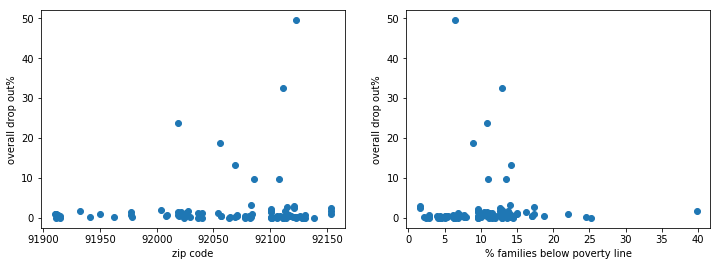

In [103]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4));

ax1.scatter(df_school_demographics_sd['zip_code'],
            df_school_demographics_sd['%_overall_dropout']);
ax1.set_xlabel('zip code');
ax1.set_ylabel('overall drop out%');

ax2.scatter(df_school_demographics_sd['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All families'],
            df_school_demographics_sd['%_overall_dropout']);
ax2.set_xlabel('% families below poverty line');
ax2.set_ylabel('overall drop out%');

In [62]:
df_school_demographics_sd.sort_values(by='%_overall_dropout', ascending=False).head(20)

,Id,Geography,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force,%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force,...,%_dropout_within_Filipino,%_enrolled_of_total_Hispanic,%_dropout_within_Hispanic,%_enrolled_of_total_African American,%_dropout_within_African American,%_enrolled_of_total_White,%_dropout_within_White,%_enrolled_of_total_Two or More Races,%_dropout_within_Two or More Races,%_overall_dropout
CDSCode,,,,,,,,,,,,,,,,,,,,,
37103710128538,8600000US92123,ZCTA5 92123,71.1,67.1,61.9,5.2,4.0,28.9,7.7,66.3,...,0.000000,68.080808,65.578635,15.353535,14.473684,11.111111,14.545455,2.828283,14.285714,49.494949
37103710128520,8600000US92111,ZCTA5 92111,65.5,64.2,58.8,5.3,1.4,34.5,8.3,60.4,...,33.333333,82.886335,33.898305,6.513410,19.607843,6.130268,29.166667,1.915709,13.333333,32.439336
37680490132506,8600000US92019,ZCTA5 92019,62.4,62.0,54.6,7.4,0.5,37.6,12.0,55.8,...,0.000000,41.262136,21.176471,6.796117,28.571429,42.718447,26.136364,2.427184,20.000000,23.786408
37735693731221,8600000US92056,ZCTA5 92056,61.2,59.0,53.9,5.0,2.2,38.8,8.5,54.3,...,20.000000,53.474320,17.514124,4.229607,42.857143,29.003021,21.875000,10.574018,8.571429,18.731118
19753090132654,8600000US92069,ZCTA5 92069,61.7,61.2,57.2,4.0,0.5,38.3,6.5,52.3,...,0.000000,39.577039,18.320611,11.480363,21.052632,34.138973,4.424779,7.250755,16.666667,13.293051
37754160132472,8600000US92086,ZCTA5 92086,34.9,34.9,28.4,6.5,0.0,65.1,18.5,30.6,...,100.000000,43.006993,5.691057,3.146853,22.222222,44.405594,10.236220,6.643357,26.315789,9.790210
37682130123224,8600000US92108,ZCTA5 92108,74.6,68.7,63.3,5.4,5.9,25.4,7.8,71.3,...,0.000000,49.557522,11.309524,5.309735,0.000000,31.268437,3.773585,7.669617,19.230769,9.734513
37684520114264,8600000US92083,ZCTA5 92083,62.4,61.0,57.9,3.1,1.4,37.6,5.1,53.4,...,NaN,48.447205,2.564103,1.863354,0.000000,36.645963,5.084746,10.559006,0.000000,3.105590
37683383731395,8600000US92121,ZCTA5 92121,69.4,69.4,66.4,3.0,0.0,30.6,4.3,65.5,...,0.000000,53.030303,2.857143,9.090909,3.333333,33.030303,1.834862,1.060606,14.285714,3.030303


## Get the model and fit with zip code

It doesn't seem like it would make sense to do a linear regression fit, but let's see what would happen anyway.

I followed this [link](https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f)

In [160]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [122]:
# Assign standard scikit-learn variables
# (note, I will assigning a vector of 1's for Beta-0 term; will ignore settingwithcopy warning)
# df_school_demographics_sd.loc[:, 'beta0_term'] = np.ones(df_school_demographics_sd.shape[0])

# X = df_school_demographics_sd.loc[:, ['beta0_term', 'zip_code']].copy()
# y = df_school_demographics_sd.copy()['%_overall_dropout']

In [123]:
# Alternative - use reshape
X = df_school_demographics_sd.loc[:, 'zip_code'].copy().values.reshape(-1,1)
y = df_school_demographics_sd.copy()['%_overall_dropout'].copy().values.reshape(-1,1)

In [124]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [125]:
# Make model
reg = LinearRegression()
reg.fit(X_train, y_train)   # Train it

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [126]:
# Inspect beta terms
print('intercept: ', reg.intercept_)
print('coefficients: ', reg.coef_)   # Should I need 

coefficients:  [-910.72644115]
coefficients:  [[0.0099191]]


In [127]:
# Make predictions based on the model

y_pred = reg.predict(X_test)

In [142]:
df_compare = pd.DataFrame({'predictions':y_pred.flatten(), 'actual':y_test.flatten()})
df_compare.head()

,actual,predictions
0,0.575731,2.079088
1,0.051020,3.110675
2,0.848010,0.948310
3,9.790210,2.684153
4,0.000000,3.100756


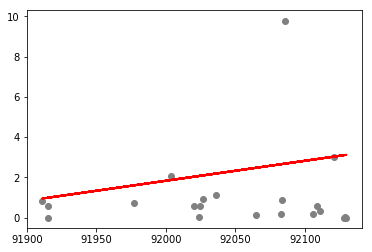

In [144]:
f, ax1 = plt.subplots(1,1)
ax1.scatter(X_test, y_test,  color='gray')
ax1.plot(X_test, y_pred, color='red', linewidth=2);

In [148]:
## Calculate errors
# the test data goes first
# find out which is most used

metrics.mean_absolute_error(y_test, y_pred)

1.9256351347695053

In [149]:
metrics.mean_squared_error(y_test, y_pred)

6.0309942868311275

In [150]:
# To get root mean squared error, you have to manually take square root
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

2.4558082756663087

In [151]:
# Calculate errors - find out which is most used
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.9256351347695053
Mean Squared Error: 6.0309942868311275
Root Mean Squared Error: 2.4558082756663087


## Add in percentage of families below median income

In [170]:
# Assign standard scikit-learn variables
# note, don't assign a vector of 1's for Beta-0 term; will ignore settingwithcopy warning)

X = df_school_demographics_sd.loc[:, ['zip_code', '%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All families']] #.values
y = df_school_demographics_sd.copy()['%_overall_dropout'] #. values

In [171]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=0)

In [173]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [177]:
# Get coefficients - why is there both an intercept and two coefficients

print('intercept: ', reg.intercept_)
print('coefficients: ', reg.coef_)    

intercept:  -917.7909628876083
coefficients:  [0.00999479 0.00924847]


In [179]:
# Get predictions
y_pred = reg.predict(X_test)

In [181]:
# Compare actual vs. predictions (don't do scatter since it's two variables)

df_compare = pd.DataFrame({'predictions':y_pred, 'actual':y_test})
df_compare.head(10)

,actual,predictions
CDSCode,,
37681063730058,0.575731,2.137318
37682963730074,0.051020,3.060245
37684113730801,0.848010,0.965543
37754160132472,9.790210,2.713706
37682963730819,0.000000,3.031754
37683383731395,3.030303,2.953466
37679833730447,2.054795,1.889509
37683383735750,0.156658,2.828516
37684523738705,0.871632,2.687242


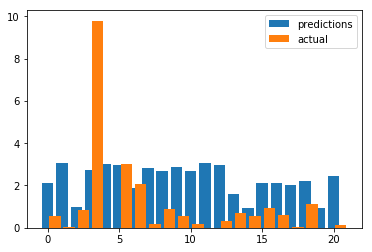

In [193]:
f, ax1 = plt.subplots(1,1)
ax1.bar(range(len(df_compare)), df_compare['predictions'], label='predictions')
ax1.bar([i+0.5 for i in range(len(df_compare))], df_compare['actual'], label='actual')
ax1.legend();



In [195]:
# Calculate errors

print('mean absolute error: ', metrics.mean_absolute_error(y_test, y_pred))
print('mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('root mean squared error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

mean absolute error:  1.916093035272894
mean squared error:  5.954116089138241
root mean squared error:  2.4401057536791804


Compared with above

**Zip code only**
Mean Absolute Error: 1.9256351347695053  <br>
Mean Squared Error: 6.0309942868311275  <br>
Root Mean Squared Error: 2.4558082756663087  <br>

**Zip code and percent of families below poverty line**

mean absolute error:  1.916093035272894 <br>
mean squared error:  5.954116089138241  <br>
root mean squared error:  2.4401057536791804

An additional feature helped but still pretty far from a good prediction

Next steps:

Have to remember that features have to be on the same scale!
And zip code is really categorical!


## Get model with just percent below poverty level

In [212]:
# Assign standard scikit-learn variables
# note, don't assign a vector of 1's for Beta-0 term; will ignore settingwithcopy warning)

X = df_school_demographics_sd.loc[:, '%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All families'].values.reshape(-1,1)
y = df_school_demographics_sd.copy()['%_overall_dropout'].values.reshape(-1,1)

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

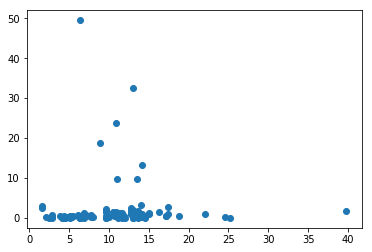

In [234]:
f, ax1 = plt.subplots(1,1)

ax1.scatter(X, y)

In [214]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [218]:
# print coefficients
print(reg.intercept_)
print(reg.coef_)

[2.38015231]
[[-0.02593134]]


In [228]:
# Plot model
y_pred = reg.predict(X_test)

In [231]:
# Compare predictions
df_compare = pd.DataFrame({'predictions':y_pred.flatten(), 'actual':y_test.flatten()})
df_compare.head(10)

,actual,predictions
0,0.000000,2.214192
1,1.140065,2.079349
2,0.316256,2.240123
3,0.412201,2.237530
4,0.569337,2.183074
5,0.000000,2.131211
6,1.449953,2.097501
7,3.105590,2.017114
8,0.146628,2.126025
9,0.705053,2.107873


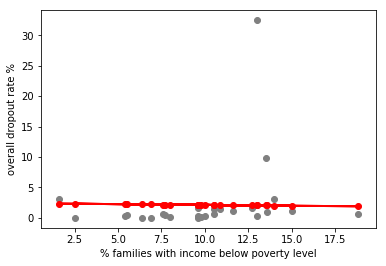

In [304]:
f, ax1 = plt.subplots(1,1)
ax1.scatter(X_test, y_test,  color='gray')
ax1.scatter(X_test, y_pred,  color='red')
ax1.plot(X_test, y_pred, color='red', linewidth=2);
ax1.set_xlabel('% families with income below poverty level')
ax1.set_ylabel('overall dropout rate %');

In [242]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

2.810321038321701
40.13759130648476
6.335423530158403


## Find features that actually correlate. Get Pearson's across all.

In [509]:
# Limit to features that are based on percentage so that I know they're on a similar scale
df_school_demographics_sd_pct = df_school_demographics_sd.loc[:, df_school_demographics_sd.columns.str.contains('%')]

In [510]:
# Get Pearson's with at least 3/4 of observations required per pair of columns to have valid result
df_pct_corr = df_school_demographics_sd_pct.corr(method='pearson', min_periods=round(0.75*len(df_school_demographics_sd_pct.index)))

In [514]:
# Find a feature that negatively correlates the most with this one

df_pct_corr.loc['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people', :].sort_values()

%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage                                                                           -0.778749
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ private health insurance                                             -0.762305
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. 18-64 yrs - In labor force: - Employed: - w/ health ins coverage - w/ private health insurance     -0.740673
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. 18-64 yrs - In labor force: - Employed: - w/ health ins coverage                                   -0.722669
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. 18-64 yrs - Not in labor force: - w/ health ins coverage - w/ private health insurance             -0.715494
%; INCOME_BENEFITS - Total households - $100,000 to $149,999                                                                                               

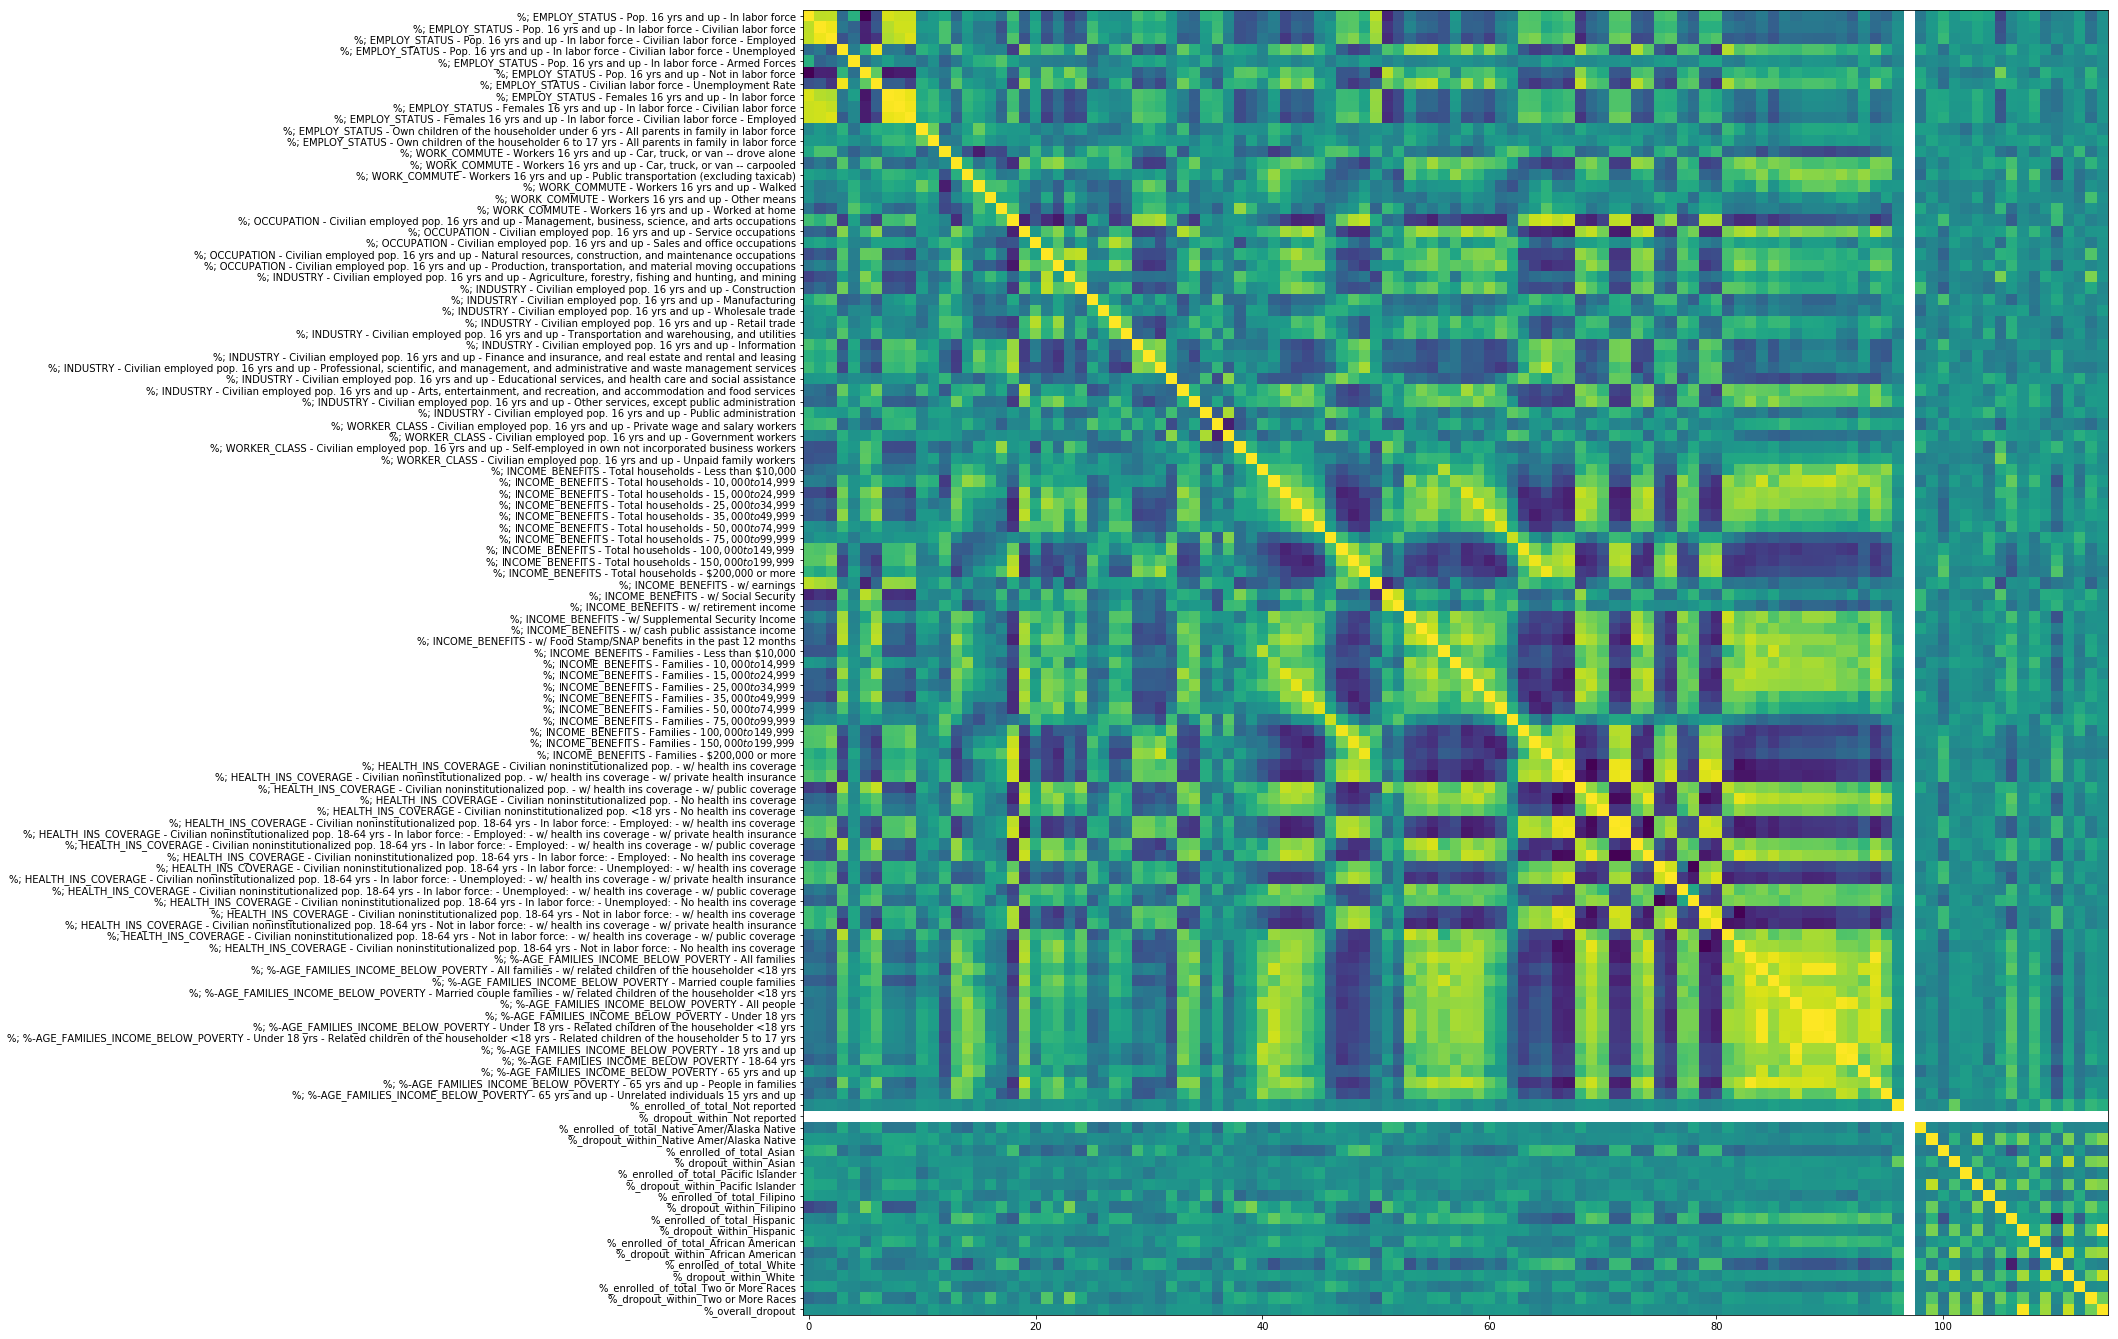

In [283]:
#f, (ax1, ax2) = plt.subplots(2, 1, figsize=(64,24))
f, (ax1) = plt.subplots(1, 1, figsize=(64,24))
ax1.imshow(df_pct_corr);
ax1.set_yticks(np.arange(0, len(df_school_demographics_sd_pct.columns), 1));
ax1.set_yticklabels(df_school_demographics_sd_pct.columns);


# ax2.imshow(df_pct_corr);
# ax2.set_yticks(np.arange(0, len(df_school_demographics_sd_pct.columns), 1));
# #ax2.set_yticklabels(df_school_demographics_sd_pct.columns);

# plt.tight_layout()

### Include all state data

In [288]:
# Limit to features that are based on percentage so that I know they're on a similar scale
df_school_demographics_pct = df_school_demographics.loc[:, df_school_demographics.columns.str.contains('%')]
# Get Pearson's with at least 3/4 of observations required per pair of columns to have valid result
df_pct_corr = df_school_demographics_pct.corr(method='pearson', min_periods=round(0.75*len(df_school_demographics_pct.index)))

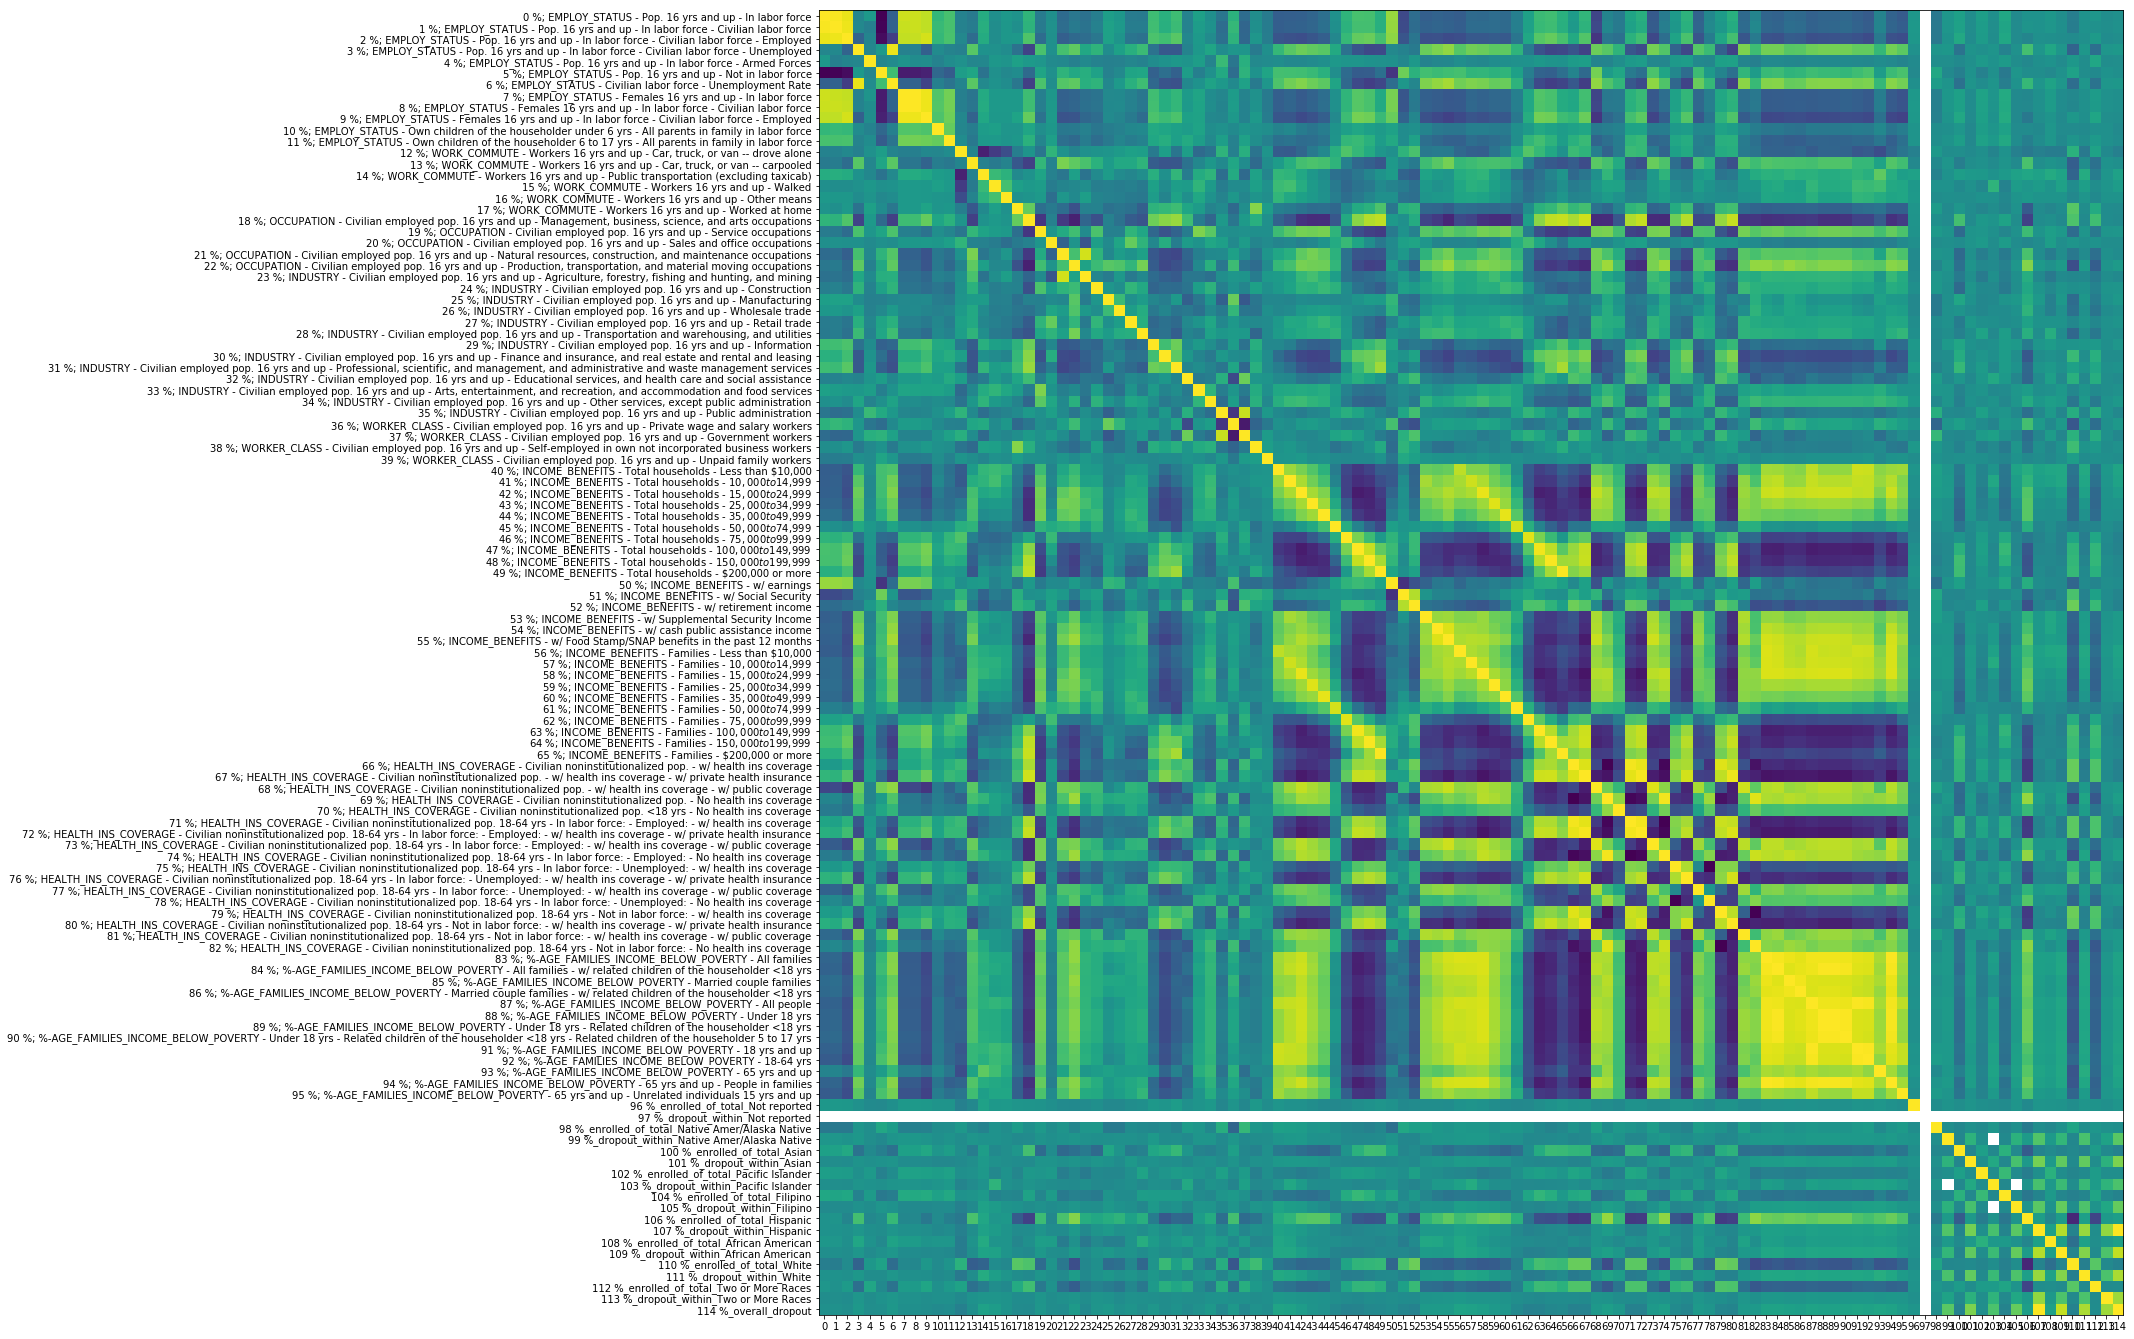

In [302]:
#f, (ax1, ax2) = plt.subplots(2, 1, figsize=(64,24))
f, (ax1) = plt.subplots(1, 1, figsize=(64,24))
ax1.imshow(df_pct_corr);
ax1.set_yticks(np.arange(0, len(df_school_demographics_sd_pct.columns), 1));
ax1.set_yticklabels([str(i) + ' ' + feature for (i, feature) in enumerate(df_school_demographics_pct.columns)]);
ax1.set_xticks(np.arange(0, len(df_school_demographics_sd_pct.columns), 1));
ax1.set_xticks(np.arange(0, len(df_school_demographics_pct.columns), 1));

plt.savefig('correlations.png')

In [305]:

X = df_school_demographics.loc[:, '%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All families'].values.reshape(-1,1)
y = df_school_demographics.copy()['%_overall_dropout'].values.reshape(-1,1)

In [310]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# verify splits
y_train.shape

In [317]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [319]:
# view coefficients
print('intercept: ', reg.intercept_)
print('coefficients: ', reg.coef_)

intercept:  [0.29165852]
coefficients:  [[0.12383914]]


In [321]:
# Make predictions based on model
y_pred = reg.predict(X_test)

In [326]:
# Compare model predictions and actual y_test values
df_compare = pd.DataFrame({'predictions':y_pred.flatten(), 'actual':y_test.flatten()})
df_compare.head()

,actual,predictions
0,0.648882,0.886086
1,0.605198,0.997542
2,0.085324,1.071845
3,0.299401,0.799399
4,2.751323,3.474324


Text(0,0.5,'overall dropout rate')

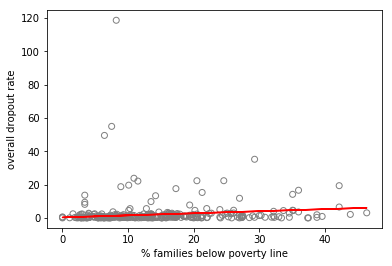

In [333]:
# Show with model
f, ax1 = plt.subplots()
ax1.scatter(X_test, df_compare['actual'], facecolors='none', edgecolors='gray')
ax1.plot(X_test, df_compare['predictions'], color='red');
ax1.set_xlabel('% families below poverty line')
ax1.set_ylabel('overall dropout rate')

## Hard to tell if there's an effect using dropout percentage as a continuous variable. Try putting dropout rates into categories.

Originally had:
- low dropout rate (0-1%)
- average dropout rate is 1.5% (1-2%)
- severe dropout rate is 1.5% (2-5%)
- very severe dropout rate is 1.5% (>5%)



### Try quantiles and qcut

- very low (dropout rate is lowest 20% of schools), <0.186% dropout rate
- low (dropout rate is 20-40% percentile of schools), 0.186% to 0.457% dropout rate
- average (dropout rate is 40-60% percentile of schools), 0.457% to 0.898% dropout rate
- severe (dropout rate 60-80% percentile of schools), 0.898% to 1.846% dropout rate
- very severe (dropout rate 80-100% percentile of schools), >1.846% dropout rate

In [349]:
np.arange(0, 1.2, 0.2)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [348]:
df_school_demographics['%_overall_dropout'].median()

0.6194099369536752

In [350]:
df_school_demographics['%_overall_dropout'].quantile(np.arange(0, 1.2, 0.2))

0.0      0.000000
0.2      0.186387
0.4      0.456669
0.6      0.897524
0.8      1.845797
1.0    118.596059
Name: %_overall_dropout, dtype: float64

In [363]:
df_school_demographics['dropout_rate_category'] = pd.qcut(df_school_demographics['%_overall_dropout'], 5, labels=['very low', 'low', 'average', 'high', 'very high'])
df_school_demographics['dropout_rate_category'].head(10)

CDSCode
19647330106849          low
19647330124487    very high
19647330124495    very high
19647330124503    very high
19647330124511    very high
19647330124883    very high
19647331930692    very high
19647331934454    very high
19647330108894     very low
19647330126573    very high
Name: dropout_rate_category, dtype: category
Categories (5, object): [very low < low < average < high < very high]

In [368]:
# Verify qcut is putting things into bins
df_school_demographics.groupby('dropout_rate_category').count()['%_overall_dropout']

dropout_rate_category
very low     267
low          266
average      266
high         266
very high    267
Name: %_overall_dropout, dtype: int64

In [463]:
### Try pd.cut instead of pd.qcut

df_school_demographics['dropout_rate_category_pdcut'] = pd.cut(df_school_demographics['%_overall_dropout'], 6)  #, labels=['very low', 'low', 'average']) #, 'high', 'very high'])
df_school_demographics['dropout_rate_category_pdcut'].head(10)

CDSCode
19647330106849    (-0.119, 19.766]
19647330124487    (-0.119, 19.766]
19647330124495    (-0.119, 19.766]
19647330124503    (-0.119, 19.766]
19647330124511    (-0.119, 19.766]
19647330124883    (-0.119, 19.766]
19647331930692    (19.766, 39.532]
19647331934454    (-0.119, 19.766]
19647330108894    (-0.119, 19.766]
19647330126573    (-0.119, 19.766]
Name: dropout_rate_category_pdcut, dtype: category
Categories (6, interval[float64]): [(-0.119, 19.766] < (19.766, 39.532] < (39.532, 59.298] < (59.298, 79.064] < (79.064, 98.83] < (98.83, 118.596]]

In [464]:
# Inspect group sizes when pdcut is putting things into bins
df_school_demographics.groupby('dropout_rate_category_pdcut').count()['%_overall_dropout']

dropout_rate_category_pdcut
(-0.119, 19.766]    1301
(19.766, 39.532]      25
(39.532, 59.298]       3
(59.298, 79.064]       2
(79.064, 98.83]        0
(98.83, 118.596]       1
Name: %_overall_dropout, dtype: int64

## Apply model using dropout_rate_category as the target to predict

Note that the new "dropout_rate_category" is categorical but also ordinal (the categories have some intuitive order). How is this treated?

https://towardsdatascience.com/7-data-types-a-better-way-to-think-about-data-types-for-machine-learning-939fae99a689

Let's assume it's nominal for now

In [378]:
from sklearn.linear_model import LogisticRegression

In [373]:
#  Use one-hot encoding for dummy categorical variables

df_school_demographics['dropout_rate_category_ohe'] = df_school_demographics['dropout_rate_category'].replace({'very low':0,
                                                         'low':1,
                                                         'average':2,
                                                         'high':3,
                                                         'very high':4})

In [402]:
df_school_demographics_pct.columns

Index(['%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force',
       '%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force',
       '%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed',
       '%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed',
       '%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces',
       '%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force',
       '%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate',
       '%; EMPLOY_STATUS - Females 16 yrs and up - In labor force',
       '%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force',
       '%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed',
       ...
       '%_dropout_within_Filipino', '%_enrolled_of_total_Hispanic',
       '%_dropout_within_Hispanic', '%_enrolled_of_total_African American',
       '%_dr

In [418]:
# Let's use the percent families below poverty line for now
X = df_school_demographics.loc[:, '%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All families'].values.reshape(-1,1)

# Use newly made categorical variable
y = df_school_demographics.copy()['dropout_rate_category_ohe'].values #.reshape(-1,1)

In [419]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [420]:
log_reg = LogisticRegression()
log_reg.fit(X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [421]:
# intercepts and coefficients
print('intercept: ', log_reg.intercept_)
print('coefficients: ', log_reg.coef_)

intercept:  [-0.41410075 -0.92803577 -1.46899101 -1.31070605 -2.25684933]
coefficients:  [[-0.07602275]
 [-0.02870483]
 [-0.00829658]
 [ 0.00657147]
 [ 0.05666601]]


In [422]:
# make predictions and do comparisons
y_pred = log_reg.predict(X_test)

In [423]:
df_compare = pd.DataFrame({'predicted':y_pred, 'actual':y_test})
df_compare.head(10)

,actual,predicted
0,2,0
1,1,0
2,3,3
3,4,4
4,3,0
5,4,4
6,2,3
7,2,3
8,4,3
9,4,4


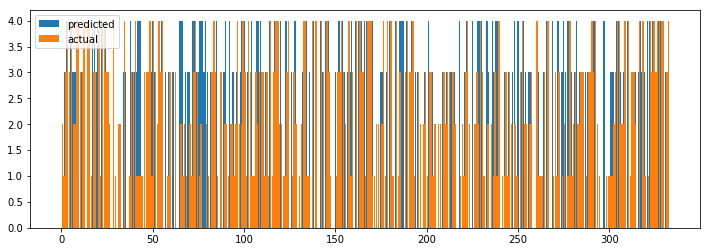

In [424]:
f, ax1 = plt.subplots(1,1, figsize=(12, 4))
ax1.bar(range(len(df_compare)), df_compare['predicted'], label='predicted')
ax1.bar([i+0.5 for i in range(len(df_compare))], df_compare['actual'], label='actual')
ax1.legend();


In [451]:
# Errors
print('mean absolute error: ', metrics.mean_absolute_error(y_test, y_pred))
print('mean squared error: ', metrics.mean_squared_error(y_test, y_pred))

mean absolute error:  1.4984984984984986
mean squared error:  3.720720720720721


In [438]:
## Use multiple features


col2get = ['%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage',
           '%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All families',
           '%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)']

In [439]:
# Let's use the percent families below poverty line for now
X = df_school_demographics.loc[:, col2get].values

# Use newly made categorical variable
y = df_school_demographics.copy()['dropout_rate_category_ohe'].values #.reshape(-1,1)

In [445]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [446]:
# Fit the model

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [448]:
print('intercept: ', log_reg.intercept_)
print('coefficients: ', log_reg.coef_)

intercept:  [-1.4047006  -0.62369277 -0.57993671  1.19233276 -0.15266095]
coefficients:  [[ 0.00689699 -0.03497188 -0.01786723]
 [-0.00319772 -0.01647559 -0.05664616]
 [-0.0046383  -0.03196836 -0.00505424]
 [-0.03141108  0.00543926 -0.01549068]
 [-0.02382866  0.03416972  0.04625183]]


In [449]:
# predictions
y_pred = log_reg.predict(X_test)

In [450]:
# Compare predicted vs. actual
df_compare = pd.DataFrame({'predicted': y_pred, 'actual': y_test})
df_compare.head(10)

,actual,predicted
0,2,0
1,2,1
2,4,1
3,4,4
4,1,0
5,3,4
6,2,0
7,1,4
8,1,0
9,2,4


In [453]:
y_pred

array([0, 1, 1, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 1, 0, 1, 4, 1, 0, 0, 0, 1,
       1, 4, 0, 0, 4, 1, 4, 3, 0, 1, 4, 1, 4, 4, 1, 0, 1, 1, 1, 3, 1, 0,
       0, 1, 1, 1, 1, 0, 4, 3, 0, 4, 1, 1, 4, 0, 3, 1, 4, 4, 1, 4, 4, 4,
       1, 1, 0, 0, 1, 4, 4, 0, 0, 0, 1, 4, 4, 0, 4, 0, 0, 1, 4, 4, 4, 0,
       4, 1, 4, 1, 4, 1, 1, 1, 0, 4, 4, 0, 4, 1, 1, 4, 4, 1, 1, 1, 4, 1,
       0, 4, 0, 0, 3, 1, 3, 3, 4, 4, 4, 0, 1, 1, 0, 4, 4, 4, 4, 1, 1, 0,
       0, 1, 1, 1, 1, 3, 0, 0, 1, 1, 0, 1, 1, 3, 0, 3, 1, 4, 4, 0, 0, 1,
       1, 0, 3, 0, 4, 1, 1, 0, 4, 0, 3, 4, 0, 4, 4, 1, 1, 0, 4, 4, 0, 1,
       4, 3, 0, 1, 4, 0, 0, 1, 4, 1, 1, 1, 0, 4, 0, 0, 3, 4, 0, 1, 4, 4,
       0, 4, 4, 0, 4, 4, 4, 0, 1, 0, 3, 2, 3, 0, 3, 1, 0, 4, 4, 4, 4, 3,
       0, 0, 0, 0, 1, 1, 4, 0, 0, 4, 4, 1, 0, 3, 4, 4, 4, 1, 4, 1, 1, 1,
       0, 0, 1, 4, 0, 4, 4, 4, 0, 1, 1, 1, 0, 1, 4, 1, 1, 0, 4, 1, 0, 1,
       0, 4, 0, 0, 1, 1, 0, 0, 4, 1, 2, 1, 0, 1, 4, 1, 0, 0, 0, 4, 1, 0,
       0, 4, 4, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 3, 4,

In [452]:
# Error metrics

print('mean absolute error: ', metrics.mean_absolute_error(y_test, y_pred))
print('mean squared error: ', metrics.mean_squared_error(y_test, y_pred))

mean absolute error:  1.4984984984984986
mean squared error:  3.720720720720721


In [414]:
## Above sucks - just try using everything
X = df_school_demographics_pct.iloc[:, 1:50]

# Use newly made categorical variable
y = df_school_demographics.copy()['dropout_rate_category_ohe'].values #.reshape(-1,1)

In [455]:
X.shape

(1332, 3)

In [454]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [417]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [485]:
pd.set_option('max_columns', None)
df_school_demographics_sd_pct

,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force,%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed,%; EMPLOY_STATUS - Own children of the householder under 6 yrs - All parents in family in labor force,%; EMPLOY_STATUS - Own children of the householder 6 to 17 yrs - All parents in family in labor force,"%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone","%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled",%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab),%; WORK_COMMUTE - Workers 16 yrs and up - Walked,%; WORK_COMMUTE - Workers 16 yrs and up - Other means,%; WORK_COMMUTE - Workers 16 yrs and up - Worked at home,"%; OCCUPATION - Civilian employed pop. 16 yrs and up - Management, business, science, and arts occupations",%; OCCUPATION - Civilian employed pop. 16 yrs and up - Service occupations,%; OCCUPATION - Civilian employed pop. 16 yrs and up - Sales and office occupations,"%; OCCUPATION - Civilian employed pop. 16 yrs and up - Natural resources, construction, and maintenance occupations","%; OCCUPATION - Civilian employed pop. 16 yrs and up - Production, transportation, and material moving occupations","%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining",%; INDUSTRY - Civilian employed pop. 16 yrs and up - Construction,%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing,%; INDUSTRY - Civilian employed pop. 16 yrs and up - Wholesale trade,%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Transportation and warehousing, and utilities",%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information,"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Finance and insurance, and real estate and rental and leasing","%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services","%; INDUSTRY - Civilian employed pop. 16 yrs and up - Educational services, and health care and social assistance","%; INDUSTRY - Civilian employed pop. 16 yrs and up - Arts, entertainment, and recreation, and accommodation and food services","%; INDUSTRY - Civilian employed pop. 16 yrs and up - Other services, except public administration",%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration,%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers,%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Government workers,%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Self-employed in own not incorporated business workers,%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Unpaid family workers,"%; INCOME_BENEFITS - Total households - Less than $10,000","%; INCOME_BENEFITS - Total households - $10,000 to $14,999","%; INCOME_BENEFITS - Total households - $15,000 to $24,999","%; INCOME_BENEFITS - Total households - $25,000 to $34,999","%; INCOME_BENEFITS - Total households - $35,000 to $49,999","%; INCOME_BENEFITS - Total households - $50,000 to $74,999","%; INCOME_BENEFITS - Total households - $75,000 to $99,999","%; INCOME_BENEFITS - Total households - $100,000 to $149,999","%; INCOME_BENEFITS - Total households - $150,000 to $199,999","%; INCOME_BENEFITS - Total 

In [486]:
df_school_demographics_sd_pct.to_csv('df_school_demographics_sd_pct.csv')

## Using GreatSchools information

https://www.greatschools.org/api/docs/technical-overview/

https://www.greatschools.org/gk/about/api-terms-use/

In [ ]:
# test output

<script type="text/javascript">
//<![CDATA[
window.gon={};gon.ad_set_targeting={"env":"prod","page_name":"GS:SchoolP","City":"Truckee","county":"Placer","gs_rating":"7","level":"m","school_id":"13978","State":"CA","type":"public","zipcode":"96161","district_id":"509","template":"SchoolProf","number_of_reviews_with_comments":"13","city_long":"Truckee","address":"10931 Alder Drive"};gon.advertising_enabled=true;gon.ad_set_channel_ids="";gon.ab_value=null;gon.signed_in=false;gon.translations={"compare_test_scores_for":"Compare test scores for","compare_pinned_school":"COMPARE THIS SCHOOL TO SCHOOLS BELOW","from":"from","and":"and","to_nearby_schools":"to nearby schools within","Academics":"Academics","Saved!":"Saved!","Saved":"Saved","Save":"Save","No listings found":"No listings found","# of schools":"# of schools","# of students":"# of students","in":"in","no_info":"Currently, this information is unavailable. For more information","visit our FAQ page":"visit our FAQ page","at a glance":"at a glance","find_schools_in":"Find schools in","see_all_winners_in":"See all winners in","awards_and_badges":"Awards \u0026 Badges","award":"award","awards":"awards","award_winner":"Award winner","award_winners":"Award winners","award_winning_high_schools":"Award-winning high schools","award-winning-schools":"Award-winning schools","assigned_school":"Assigned school","browse_school_blurb":"Here's a look at schools in","browse_school_blurb_district":"Here's a look at the district","browse-schools":"Browse schools","calendar":"calendar","cities":"Cities","city_hero_html":"\u003cdiv class=\"city-hero-narrative\"\u003e{city} is a city in {county} county, {stateLong}\u003c/div\u003e","city_hero_no_county_html":"\u003cdiv class=\"city-hero-narrative\"\u003e{city} is a city in {stateLong}\u003c/div\u003e","neighboring-cities":"Neighboring cities","state.state_hero_narrative_html":"There are {schoolCount} public and private PK-12 schools in {nameLong}. Learn more about the schools, student demographics, and academics within the state, read parent reviews of local schools, and find information about specific cities and school districts.","state.state_hero_title":"{nameLong} Schools","state.districts_header":"Largest school districts in {nameLong}","state.explore_in_state":"Explore schools in {nameLong}","state.explore_by_type":"Explore schools by type","state.cities_browse_more_button":"See all cities","state.districts_browse_more_button":"See all districts","state.see_award_winning_schools":"See award-winning schools","community_resources":"community resources","county":"county","data_not_provided_by_the_school":"Data not provided by the school","date":"Date","district_calendar":"District calendar","district_calendar_no_results":"Currently, this information is not available.","district_calendar_verified":"This calendar is being updated by a verified administrator.","district_calendar_sources_html":"\u003cdiv class=\"sources-text\"\u003e\n  \u003ch3\u003eGreatSchools district data sources \u0026 information\u003c/h3\u003e\n  \u003cdiv\u003eCalendar\u003c/div\u003e\n  \u003cp\u003e\u003cspan\u003eSources\u0026#58;\u003c/span\u003e Tandem\u003c/p\u003e\n\u003c/div\u003e\n","districts":"Districts","Email":"Email","Permalink":"Permalink","schools_in_district":"Schools in district","school_grade":"School Grade","additional_school_type":"Additional school type","enter_an_address_to_see_schools":"Enter an address to see schools","search_or_click_map_for_districts":"Search or click map for districts","view_in_map":"View in map","event":"Event","website":"Website","homes_for_sale":"Homes for sale","nearby_homes_for_sale":"Nearby homes for sale","nearby homes for sale \u0026 rent":"nearby homes for sale \u0026 rent","Mile":"Mile","Miles":"Miles","Relevance":"Relevance","Suggestions":"Suggestions","no_results_suggestions":["Make sure all words are spelled correctly.","Try different or fewer keywords.","Try more general keywords.","Try different search filters (e.g. school types or levels)."],"no_compare_school_title":"No results found","no_compare_school_results":"We couldn’t find nearby schools with test scores from {breakdown} students.","try_increasing_distance":"Try increasing the distance for nearby schools.","Close filters":"Close filters","school":"school","schools":"schools","Type":"Type","Grades":"Grades","Total students enrolled":"Total students enrolled","Students per teacher":"Students per teacher","Reviews":"Reviews","Next":"Next","Previous":"Previous","Sort by":"Sort by","GreatSchools Rating":"GreatSchools Rating","School name":"School name","Distance":"Distance","Filter":"Filter","Currently unrated":"Currently unrated","rating_description_html":"\u003cp style=\"text-align: left;\"\u003eGreatSchools’ Summary Rating provides an overall snapshot of school quality. Ratings follow a 1-10 scale: \u003cul style=\"text-align: left;\"\u003e\u003cli\u003eratings between 1-4 signal “below average”\u003c/li\u003e \u003cli\u003e5-6 indicate “average”\u003c/li\u003e \u003cli\u003eratings of 7-10 are “above average”\u003c/li\u003e\u003c/ul\u003e\u003c/p\u003e\n","no_rating_description_html":"\u003cp style=\"text-align: left;\"\u003e GreatSchools’ Summary Rating provides an overall snapshot of school quality. \u003cbr/\u003eFor some schools, we do not have enough data from state or national education agencies to provide a rating.\u003c/p\u003e\n","assigned_description_html":"It looks like this is your assigned \u003cspan style='text-transform: lowercase;' class=\"open-sans_sb\"\u003e{school_level} school\u003c/span\u003e, but we recommend double-checking with the district or school.\n","advertisement":"Advertisement","assigned":"ASSIGNED","Preschools":"Preschools","PreK":"PreK","Elementary":"Elementary","Elementary schools":"Elementary schools","Middle":"Middle","Middle schools":"Middle schools","High":"High","High schools":"High schools","All schools":"All schools","ListMap view":"ListMap view","map":"map","Table view":"Table view","Filter by":"Filter by","School type and level":"School type and level","school districts":"school districts","Public school":"Public school","Public schools":"Public schools","Private school":"Private school","Private schools":"Private schools","Public \u0026 private schools":"Public \u0026 private schools","Public charter schools":"Public charter schools","Public district schools":"Public district schools","Public school districts in":"Public school districts in","Public district \u0026 private schools":"Public district \u0026 private schools","Public charter \u0026 private schools":"Public charter \u0026 private schools","Charter":"Charter","District":"District","Share":"Share","yes":"Yes","no":"No","close":"Close","edit":"Edit","learn_more_html":"Learn More \u0026raquo;","mobility.title":"Community resources in","mobility.transportation_narration":"Transportation options near the schools","mobility.help":"MobilityScore® helps you understand how easy it is to get around. It works at any location or  address within the US and Canada and gives you a score ranging from 0 (no mobility choices)  to 100 (excellent mobility choices). MobilityScore takes into account all your options, from  public transit to carsharing, bikesharing, ridesharing, bikes, and even scooters!\n","mobility.sources_html":"\u003cdiv class=\"sources-text\"\u003e\n  \u003ch3\u003eGreatSchools community data sources \u0026 information\u003c/h3\u003e\n  \u003cdiv\u003eTransportation\u003c/div\u003e\n  \u003cp\u003e\u003cspan\u003eSources\u0026#58;\u003c/span\u003e MobilityScore\u0026reg;\u003c/p\u003e\n\u003c/div\u003e\n","mobility.no_score_city":"This section shows the transportation option offered at this city. Currently, this information is not available.","mobility.no_score_district":"This section shows the transportation option offered in this district. Currently, this information is not available.","fatal_error":"An unexpected error occurred while loading the page. Please try refreshing the page.","fewer_filters":"Fewer filters","follow_schools.signed_in_message":"Good news! You’re signed up to receive our newsletter and updates on","follow_schools.signed_in_message_with_no_school_name":"Good news! You’re signed up to receive our newsletter and updates for this school.","follow_schools.signed_in_message_on_compare_follow_all":"Good news! You’re signed up to receive our newsletter and updates for these schools.","more_filters":"More filters","ok_fit":"Ok fit","Overview":"Overview","Ratings Snapshot":"Ratings Snapshot","Equity Test Scores":"Equity: Test scores","reviews.found_this_helpful":" found this helpful","reviews.people":"people","reviews.person":"person","reviews.share_review_caption":"User review of ","reviews.reviews":"reviews","reviews.review":"review","reviews.No reviews yet":"No reviews yet","school_picker.city":"city","school_picker.school":"school","school_picker.select":"Select ","school_picker.do_not_see_school_text":"Don't see your school?","school_picker.placeholder":"Enter school","school_picker.return_to_original_search_text":"Return to original search","school_picker.select_state":"Select state","school_types.Private":"Private","school_types.Public charter":"Public charter","school_types.Charter":"Public charter","school_types.Public district":"Public district","school_types.Public":"Public district","school_types.charter":"charter","school_types.private":"private","school_types.public":"public","search":"Search","search_form.long_placeholder":"Find a great school","search_form.short_placeholder":"City, zip, address or school","search_help.help":"Help","search_help.greatschool_rating":"GreatSchools' Summary Rating provides an overall snapshot of school quality. Ratings follow a 1-10 scale:","search_help.rating.below_average_html":"Below\u003cbr/\u003eaverage","search_help.rating.average_html":"Average","search_help.rating.above_average_html":"Above\u003cbr/\u003eaverage","search_help.currently_rated":"Currently unrated schools:","search_help.currently_rated_info":"For some schools, we do not have enough data from state or national education agencies to provide a rating.","search_help.search_suggestions":"Help us improve the new search","search_help.send_feedback":"Send Feedback","saved_search_validation_error":"Please name your search","strong_fit":"Strong fit","test_scores.title":"Test Scores","test_scores.advanced":"Advanced","test_scores.proficient":"Proficient","test_scores.proficient_or_better":"Proficient or better","test_scores.at_grade_level":"Proficient","This school":"This school","top_schools.state_top_schools_header":"Best public schools in {state}","top_schools.top_schools":"Top schools","top_schools.top_schools_blurbs":"These are some of the top-rated public schools in {name} \u003ca href=\"/gk/ratings/#summary-rating\"\u003ebased on a variety of measures\u003c/a\u003e, including academic performance and \u003ca href=\"gk/ratings/#equityrating\"\u003eequity\u003c/a\u003e. Click to see the full list of schools sorted by rating. \u003ca href=\"/gk/ratings/\"\u003eAbout the GreatSchools rating\u003c/a\u003e\n","top_schools.csa_top_schools_blurb":"These are some of the best public high schools in {name} at preparing students for success in college. The \u003ca href=\"/gk/csa-winners/\"\u003eCollege Success Award\u003c/a\u003e recognizes schools that do an exemplary job getting students to enroll in and stick with college, including those that beat the odds by better serving low-income students.\n","top_schools.learn_more":"Learn more","top_schools.no_elemCity":"There are no elementary schools with a GreatSchools rating for this city","top_schools.no_midCity":"There are no middle schools with a GreatSchools rating for this city","top_schools.no_highCity":"There are no high schools with a GreatSchools rating for this city","top_schools.no_elemDistrict":"There are no elementary schools with a GreatSchools rating for this district","top_schools.no_midDistrict":"There are no middle schools with a GreatSchools rating for this district","top_schools.no_highDistrict":"There are no high schools with a GreatSchools rating for this district","top_schools.see_elem":"See more elementary schools","top_schools.see_mid":"See more middle schools","top_schools.see_high":"See more high schools","recent_reviews.title":"Recent school reviews from schools in","recent_reviews.review_for":"Review for","recent_reviews.district_blurb":"Does your child attend a school in this district?","recent_reviews.city_blurb":"Does your child attend a school in this city?","recent_reviews.Add a review":"Add a review","State average":"State average","too_many_schools_error_html":"\u003cstrong\u003eYou\u0026#39ve already selected 4 schools to compare.\u0026nbsp\u003c/strong\u003e\u003ca class=\"pointer js-compareSchoolsSubmit\"\u003e\u0026nbspCompare schools.\u003c/a\u003e","not_rated_school":"Not rated school","school_boundary":"School boundary","district_boundary":"District boundary","view_legend":"View legend","view_less":"View less »","view_more":"View more »","weak_fit":"Weak fit","wrong_state_error_start_html":"\u003cstrong\u003eYou\u0026#39re currently comparing schools in\u0026nbsp","wrong_state_error_end_html":"\u003c/strong\u003e\u003ca class=\"pointer js-compareSchoolsSubmit\"\u003e\u0026nbspcompare schools now\u0026nbsp\u003c/a\u003eor\u003ca class=\"pointer js-clearSchoolsSubmit\" data-dismiss=\"alert\"\u003e\u0026nbspclear schools\u0026nbsp\u003c/a\u003e\u003cstrong\u003eto compare in this location.\u003c/strong\u003e","percentage of students":"% of students","of students":"of students","student":"student","students":"students","Students":"Students","student demographics":"student demographics","State avg":"State avg:","School value":"School value","Sponsored Ad":"Sponsored Listing","sponsored_tooltip_blurb":"Sponsored listings are paid advertisements. As a nonprofit, advertising helps make it possible to provide our site free to millions of parents.","RE Test scores narration":"This shows results across different races/ethnicities on {subject} test given to students once a year. Big differences may suggest that some student groups are not getting the support they need to succeed.\n","RE Grad rates narration":"This shows graduation rates for different races/ethnicities. Big differences may suggest that some students are not getting the support they need to succeed.\n","RE UC/CSU eligibility narration":"This shows the percentages of graduates who have taken the A-G required classes needed to be eligible for University of CA and CA state schools. \u003ca href=\"/gk/articles/dont-miss-these-requirements-to-get-into-college/\"\u003eFind out more\u003c/a\u003e about these requirements.\n","SD Test scores narration":"\u003cp class=\"narrative-content\"\u003eThis shows results for students with disabilities on a {subject} test given once a year. Big differences may suggest that some student groups are not getting the support they need to succeed.\u003c/p\u003e \u003chr /\u003e \u003cp class=\"parent-tip\"\u003e\u003cimg src='/assets/school_profiles/owl.png' /\u003e\u003cspan class=\"speech-bubble left\"\u003eParent tip\u003c/span\u003e\u003c/p\u003e \u003cp class=\"footnote\"\u003eAsk the school how it’s helping students with disabilities succeed.\u003c/p\u003e\n","Test scores":"Test scores","Graduation rates":"Graduation rates","UC/CSU eligibility":"UC/CSU eligibility","was_this_useful":"Was this useful?","See notes":"Sources","show_more":"Show more","show_less":"Show less","see_more_contact":"See contact info and more","english-learners":"Students learning English","english-learners-info-text":"This group includes all students classified as English language learners.","students-participating-in-free-or-reduced-price-lunch-program":"Students from low-income families","students-participating-in-free-or-reduced-price-lunch-program-info-text":"The students from low-income families designation is based on the percentage of students at this school who are eligible for free or reduced-price lunch.","Gender":"Gender","Male":"Male","Female":"Female","Strongly disagree":"Strongly disagree","Disagree":"Disagree","Neutral":"Neutral","Agree":"Agree","Strongly agree":"Strongly agree","Review Guidelines":"Review guidelines","last updated":"last updated","Cancel":"Cancel","Submit":"Submit","Required":"Required","Review this School":"Review this school","Review this school":"Review this school","Overall experience":"Overall experience","Recent Comments":"Recent comments","Be the first to review this school":"Be the first to review this school","Tell us why":"Tell us why","What is your relationship to this school?":"What is your relationship to this school?","all set":"All set! We have submitted your review. Thank you for helping other families by sharing your experiences.","Parent":"Parent","Current student":"Current student","Teacher":"Teacher","School leader":"School leader","Community member":"Community member","community resources":"community resources","Nearest high-performing":"Nearest high-performing","Nearby schools":"Nearby schools","Submitted ":"Submitted ","by a ":"by a ","More":"More","Terrible":"Terrible","Bad":"Bad","Average":"Average","Good":"Good","Great":"Great","You":"You","review_not_saved":"Your review has not been saved.","review_word_min":"Please be sure your review is 7 words or more in length","review_char_limit":"Sorry, we have a 2,500 character limit for reviews.  Please shorten your review to save it.","review_thank_you":"Thanks for your opinion! Please share some thoughts on this school in order to save your reviews.","Submitting":"Submitting","Report Review":"Report Review","Report":"Report","Show more":"Show more","Show less":"Show less","Review":"Review","Close all":"Close all","Review Reported":"Review Reported","no_data_message":"Currently, this information is not available. ","notify_me":"Update me when new information is published on this school's profile.","Advanced courses":"Advanced courses","advanced_courses_subheading_html":"A rigorous course load can help your student prepare for and get into college. \u003ca href=\"/gk/articles/13-surprising-tips-applying-to-college/#Grade_and_rigorous_class\"\u003eLearn more\u003c/a\u003e.","advanced_courses_tooltip":"The Advanced Courses Rating reflects the number of advanced courses taken per student at this school in English, STEM, Social sciences, and Foreign languages compared to the state average. \u003ca href=\"/gk/ratings/#advancedcoursesrating\" target=\"_blank\"\u003eLearn more about this rating.\u003c/a\u003e","advanced_courses_rating_tooltip":"This rating reflects the number of advanced courses taken per student at this school compared to the state average.","general_information_tooltip":"Here you can learn about this school’s hours, enrollment, sports, classes and more.","General Information":"General information","profile_data_sources_and_info":"GreatSchools profile data sources \u0026amp; information","district_data_sources_and_info":"GreatSchools district data sources \u0026amp; information","subjects":"Subjects","rating_html":"Rating\u0026nbsp;","courses":"courses","course":"course","grade":"Grade","details":"Details","source":"Source","Homes for sale":"Homes for sale","Homes for rent":"Homes for rent","Homes for sale near":"Homes for sale near","Rentals near":"Rentals near","See more listings near this school":"See more listings near this school","See more listings near this district":"See more listings near this district","See more listings near this city":"See more listings near this city","See how much you can afford to borrow":"See how much you can afford to borrow","beds":"beds","baths":"baths","bed":"bed","bath":"bath","sqft":"sqft","Studio":"Studio","Past ratings":"Past ratings","Hide past ratings":"Hide past ratings","Parent tip":"Parent tip","Continue":"Continue","Not right now":"Not right now","sources":"Sources","CSA Page.summary":"\u003cspan\u003eIn %{state}, %{total} public schools earned a College Success Award in %{year} based on their \n    success in preparing students for college and ultimately career. The College Success awards \n    recognize public high schools that stand out in getting students enrolled in - and staying \n    with - college.  \n  \u003ca href=\"/gk/csa-winners/\"\u003eLearn more\u003c/a\u003e.\n\u003c/span\u003e\n","CSA Page.summary_mobile":"\u003cspan\u003eIn %{state}, %{total} public schools have earned a %{year} GreatSchools College Success Award based on their success in preparing students for college and ultimately career. \u003ca href=\"/gk/csa-winners/\"\u003eLearn more\u003c/a\u003e.\u003c/span\u003e\n","tour1.step1":"GreatSchools is the leading national nonprofit providing school \u0026 parenting information. We collect data from state \u0026 federal sources to help you understand school quality and find the best educational opportunities for your child.","tour1.step2_title_html":"\u003cdiv class=\"tutorial-header\"\u003eSummary rating\u003c/div\u003e\u003cbr/\u003e","tour1.step2":"GreatSchools is a national nonprofit. Our Summary Rating provides you with a snapshot of this school's quality, based on multiple measures, compared to other public schools in the state.","tour1.step2_test_scores_only_title_html":"\u003cdiv class=\"tutorial-header\"\u003eTest Score Rating\u003c/div\u003e\u003cbr/\u003e","tour1.step2_test_scores_only":"GreatSchools is a national nonprofit. The Test Score Rating compares test scores at this school to other public schools in the state. In most states, a school’s overall rating is a Summary Rating based on multiple measures of school quality. This state does not provide enough data for us to calculate a Summary Rating, so we instead display the Test Score Rating.","tour1.step3_title_html":"\u003cdiv class=\"tutorial-header\"\u003eAcademics\u003c/div\u003e\u003cbr/\u003e","tour1.step3":"This section shows ratings and data for key themes related to academic success including test scores and more.","tour1.step4_title_html":"\u003cdiv class=\"tutorial-header\"\u003eEquity\u003c/div\u003e\u003cbr/\u003e","tour1.step4":"How well are different student groups served at this school? Low ratings may mean some student groups are not getting the support they need.","tour1.step5_title_html":"\u003cdiv class=\"tutorial-header\"\u003eEnvironment\u003c/div\u003e\u003cbr/\u003e","tour1.step5":"Want to learn more about the school? This section shows student demographics, student \u0026 counselor ratios, neighborhood, and more.","tour1.step6_title_html":"\u003cdiv class=\"tutorial-header\"\u003eReviews\u003c/div\u003e\u003cbr/\u003e","tour1.step6":"Here, parents and others in the school community share their experiences with this school. Please share your experience too!","tour1.step7_title_html":"\u003cdiv class=\"tutorial-header\"\u003eNearby schools\u003c/div\u003e\u003cbr/\u003e","tour1.step7":"Scroll through nearby high-performing schools so you can better understand the school options in your area.","tour1.step8_title_html":"\u003cdiv class=\"tutorial-header\"\u003eHelpful hints\u003c/div\u003e\u003cbr/\u003e","tour1.step8_p1":"Click on the \"?\" to view more info and answers to frequently asked questions.","tour1.step8_p2":"Parent tips will show useful info to help your child succeed in school.","tour1.step8_p3":"Click on \"Sources\" to view where the data comes from.","tour1.step8_parent_tips":"Parent tips","tour1.step8_sources":"Sources","tour1.step9_html":"\u003ch1\u003eAll done!\u003c/h1\u003e\u003cdiv\u003eHave a few more minutes? Learn\u003cbr/\u003emore about the school\u0026apos;s Academics,\u003cbr/\u003eEquity and Environment sections.\u003c/div\u003e\u003cbr/\u003e\u003cp\u003e\u003cbutton class=\"tour-cta js-start-second-tour active\"\u003eContinue\u003c/button\u003e\u003cdiv\u003e \u003ca class=\"js-close-school-tour\" style=\"cursor: pointer;\"\u003eNot right now \u003c/a\u003e\u003c/p\u003e\u003c/br\u003e\u003cp\u003eWas this useful? \u003ca href=\"https://s.qualaroo.com/45194/49372ef1-a8d5-47be-8507-f4a208ece19b\" target=\"_blank\"\u003eGive us your feedback\u003c/a\u003e\u003c/p\u003e\u003c/div\u003e","tour2.step1_title_html":"\u003cdiv class=\"tutorial-header\"\u003eCollege readiness\u003c/div\u003e\u003cbr/\u003e","tour2.step1":"How well does this school prepare its students for college? This section offers information about college entrance tests, Advanced Placement (AP) coursework, graduation rates and more.","tour2.step2_title_html":"\u003cdiv class=\"tutorial-header\"\u003eTest scores\u003c/div\u003e\u003cbr/\u003e","tour2.step2":"Here you'll find a snapshot of this school's proficiency levels in key subjects, based on test scores and compared to state averages, with \"Parent tips\" you can use to learn more.","tour2.step3_title_html":"\u003cdiv class=\"tutorial-header\"\u003eStudent progress\u003c/div\u003e\u003cbr/\u003e","tour2.step3":"The Student Progress Rating gives you a sense of how much academic improvement students at this school have made year-over-year (also known as “growth”) compared with other schools in the state.","tour2.step4_title_html":"\u003cdiv class=\"tutorial-header\"\u003eAdvanced courses\u003c/div\u003e\u003cbr/\u003e","tour2.step4":"This section looks at how well this school is doing in encouraging a large number of its students to take advanced courses, both overall and within key subject areas.","tour2.step5_title_html":"\u003cdiv class=\"tutorial-header\"\u003eAdvanced STEM courses\u003c/div\u003e\u003cbr/\u003e","tour2.step5":"Taking advanced STEM (science, technology, engineering, and math) courses is more important than ever for today's students.","tour2.step6_title_html":"\u003cdiv class=\"tutorial-header\"\u003eRace/ethnicity\u003c/div\u003e\u003cbr/\u003e","tour2.step6":"This section helps you understand how well a school is serving all of its students, looking at information like test scores and suspension rates for different racial and ethnic groups at this school.","tour2.step7_title_html":"\u003cdiv class=\"tutorial-header\"\u003eLow-income students\u003c/div\u003e\u003cbr/\u003e","tour2.step7":"This section looks at how well this school is serving its students from low-income families, looking at information like test scores and graduation rates.","tour2.step8_title_html":"\u003cdiv class=\"tutorial-header\"\u003eStudents with disabilities\u003c/div\u003e\u003cbr/\u003e","tour2.step8":"From this section, you can learn about test scores, chronic absenteeism and suspension rates at this school for students who have physical or learning disabilities, compared to state averages.","tour2.step9_title_html":"\u003cdiv class=\"tutorial-header\"\u003eGeneral information\u003c/div\u003e\u003cbr/\u003e","tour2.step9":"Here you will find information like the school's hours, transportation options, how to enroll, clubs and more.","tour2.step10_title_html":"\u003cdiv class=\"tutorial-header\"\u003eStudents\u003c/div\u003e\u003cbr/\u003e","tour2.step10":"The Students section offers a snapshot of the diversity of the student population at this school.","tour2.step11_title_html":"\u003cdiv class=\"tutorial-header\"\u003eTeachers \u0026 staff\u003c/div\u003e\u003cbr/\u003e","tour2.step11":"Here you can find out more about the student per teacher or counselor ratios, teacher tenure and more.","tour2.step12":"\u003cdiv\u003e\u003cimg alt=\"\" height=\"42\" src=\"/assets/school_profiles/owl.png\" style=\"vertical-align: sub;\" width=\"39\" /\u003e\u0026nbsp;\u003ch1 style=\"display:inline-block;\"\u003e\u0026nbsp;All done!\u003c/h1\u003e\u003c/div\u003e\u003cdiv\u003e\u003cp\u003eThank you for taking time to walk through our new profiles.\u0026nbsp;\u003cbr\u003e\u0026nbsp;\u003c/p\u003e\u003cp\u003eWas this useful? \u003ca id=\"school-tour-feedback\" style=\"cursor: pointer;\"\u003eGive us your feedback\u003c/a\u003e\u003c/p\u003e\u003cp\u003eDoes your child go to this school? \u003ca href=\"#Reviews\" class=\"js-close-school-tour\"\u003eReview this school\u003c/p\u003e\u003cp\u003e\u003cbutton class=\"tour-cta active js-close-school-tour\"\u003eDone\u003c/button\u003e\u003c/p\u003e\u003c/div\u003e\u003c/div\u003e","csa_callout_html":"\u003cspan class=\"csa-callout-text\"\u003eThis school is a College Success Award winner! \u003ca href='#College_readiness*College_success'\u003eSee details.\u003c/a\u003e\u003c/span\u003e\n","csa_district_schools_info_html":"The \u003ca href=\"/gk/csa-winners/\"\u003eCollege Success Awards\u003c/a\u003e recognize public high schools that stand out in ​getting students enrolled in - and staying with - college.","see_all_winning_schools":"See all winning schools","csa_winners":"College Success Award winners","csa_winner":"CSA winner","see_winning_schools_in":"See winning schools in","xq.school_board_finder":"School board finder","xq.learn_more_school_board_html":"Learn more about this district's school board and \u003ca href=\"https://xqsuperschool.org/school-board-lookup?address=%{address}\u0026utm_source=greatschools\u0026utm_medium=search_tool\u0026utm_campaign=school_board_thing\" target=\"_blank\" rel=\"nofollow\"\u003ehow you can get involved\u003c/a\u003e.","xq.powered_by_xq":"Powered by XQ","xq.sources":"\u003cdiv class=\"sourcing\"\u003e\n  \u003ch1\u003eGreatSchools district data sources \u0026 information\u003c/h1\u003e\n  \u003cdiv\u003e\n    \u003ch4\u003eSchool Board Finder\u003c/h4\u003e\n    \u003cp\u003e\u003cspan class=\"emphasis\"\u003eSource\u0026#58;\u003c/span\u003e XQ\u003c/p\u003e\n  \u003c/div\u003e\n\u003c/div\u003e\n","osp_school_info.title":"General Information","osp_school_info.edit":"Edit","osp_school_info.subtitle":"Here you can learn about this school’s hours, enrollment, sports, classes and more. An administrator from this school will need to “claim” the profile to add this information.","osp_school_info.bullet_1_html":"Are you an administrator at this school?\u003cbr /\u003e \u003ca href=\"/official-school-profile/\"\u003eClaim your school’s profile\u003c/a\u003e to edit general information and share what makes your school unique.\u003cbr /\u003e \u003ca href=\"/gk/schools/\"\u003eLearn more.\u003c/a\u003e\n","osp_school_info.bullet_2_html":"Are you a parent or student at this school?\u003cbr /\u003e %{mailto_start}Encourage school administrators%{mailto_end} to claim this school’s profile."};gon.data_layer_hash={"language":"en","page_name":"GS:SchoolProfile:SinglePage","City":"Truckee","county":"Placer","gs_rating":"7","level":"m","school_id":"13978","State":"CA","type":"public","zipcode":"96161","district_id":"509","template":"SchoolProf","number_of_reviews_with_comments":13,"city_long":"Truckee","address":"10931 Alder Drive"};gon.facebook_app_id="112862918759431";gon.dependencies={"highcharts":"/assets/highcharts-995d8719f75b4db7a9a841f2715b6045.js"};gon.school={"id":13978,"state":"CA","test_scores_only":false};gon.links={"terms_of_use":"/gk/terms/","school_review_guidelines":"/gk/review-guidelines/","session":"/gsr/api/session/","school_user_digest":"/gsr/api/school_user_digest/"};gon.ethnicity=[{"breakdown":"White","school_value":60.4},{"breakdown":"Hispanic","school_value":34.34},{"breakdown":"Two or more races","school_value":3.23},{"breakdown":"Black","school_value":0.81},{"breakdown":"Asian","school_value":0.81},{"breakdown":"American Indian/Alaska Native","school_value":0.2},{"breakdown":"Hawaiian Native/Pacific Islander","school_value":0.2}];gon.subgroup={"English learners":[{"breakdown":"All students","original_breakdown":"All students","created":"2016-07-28T00:05:51-07:00","school_value":13.745,"source":"CA Dept. of Education","year":2015,"school_value_2014":16.9043,"school_value_2015":13.745}],"Students participating in free or reduced-price lunch program":[{"breakdown":"All students","original_breakdown":"All students","created":"2018-09-14T03:59:53-07:00","school_value":33.94,"source":"NCES","year":2016,"school_value_2011":37.6936,"school_value_2014":45.8,"school_value_2015":37.5,"school_value_2016":33.94}]};gon.gender={"Male":[{"breakdown":"All students","original_breakdown":"All students","created":"2018-09-14T03:59:52-07:00","district_average":51.45,"school_value":51.52,"source":"NCES","state_average":51.38,"year":2016,"school_value_2012":46.4552,"school_value_2014":50.9165,"school_value_2015":53.3865,"school_value_2016":51.52}],"Female":[{"breakdown":"All students","original_breakdown":"All students","created":"2018-09-14T03:59:52-07:00","district_average":48.55,"school_value":48.48,"source":"NCES","state_average":48.62,"year":2016,"school_value_2012":53.5448,"school_value_2014":49.0835,"school_value_2015":46.6135,"school_value_2016":48.48}]};gon.homes_and_rentals_service_url="https://www.greatschools.org/homes-and-rentals-service";
//]]>
</script>

# Scrape subcategories
div>
        <span class="summary-rating-title ib js-rating-details">Equity Overview
          <span class="icon-caret-down rotate-text-270 move-icon"></span>
        </span>
        <span class="summary-rating-weight ib">13%</span>
          <span class="summary-rating-value ib"><span class="gs-rating circle-rating--9 circle-rating--xtra-small">
            9<span class="denominator">/10</span></span></span>
      </div>
    
    

In [ ]:
# BeautifulSoup documentation
# https://www.crummy.com/software/BeautifulSoup/bs4/doc/

# prettify makes it a little easier to read
print(soup.prettify())

### Get basic info including URLs for each school using API

sample url:
    'https://www.greatschools.org/california/chula-vista/6279-Bonita-Vista-Senior-High-School/'

In [47]:
# Test using SD schools and Sweeetwater Union High Schools
sd_zip_range

(91900, 92200)

In [945]:
# Filtering to get only active, public high schools
df_school_info_sd = df_school_info[df_school_info['County']=='San Diego']
df_school_info_sd_schools = df_school_info_sd[df_school_info_sd['School']!='No Data']
df_school_info_sd_schools = df_school_info_sd_schools[df_school_info_sd_schools['StatusType']=='Active']
df_school_info_sd_schools = df_school_info_sd_schools[df_school_info_sd_schools['SOCType']=='High Schools (Public)']
df_school_info_sd_schools_su = df_school_info_sd_schools[df_school_info_sd_schools['District'].str.contains('Sweetwater')]

In [946]:
my_gs_api = 'ba280f266dd08a53bbb322d77fbab2a4'

In [50]:
# Test query
# school = df_school_info_sd_schools_su['School'].iloc[5]
# print(school.replace(' ','-'))
# url = query_school
# socket = urllib.request.urlopen(url)


Bonita-Vista-Senior-High


In [949]:
def get_base_gs_school_info(school):
    query_school = 'https://api.greatschools.org/search/schools?key=' + my_gs_api + '&state=CA&q=' + school.replace(' ','-')
    url = query_school
    #url = query_string
    socket = urllib.request.urlopen(url)
    document2 = urllib.request.urlopen(url).read().decode()
    tree = ET.fromstring(document2)
    tag_school = list()
    text_school = list()
    for child in tree:
        for element in child:
            tag_school.append(element.tag)
            text_school.append(element.text)
    df = pd.DataFrame({'tags':tag_school, 'text':text_school})
    df = df.set_index('tags')
    #df.columns = df.iloc[0]
    #df.drop(df.index[0])
    return df

In [950]:
#school_info_list = list()
df_district = pd.DataFrame()

for index, school in enumerate(df_school_info_sd_schools_su['School']):
    # Limit to high schools
    if 'High' in school:
        df = get_base_gs_school_info(school)
        #school_info_list.append(df)
        if len(df_district.columns) < 1:
            df_district = df
            df_district.columns = [school]
        else:
            df_district[school] = df
        print(school, df.shape)

        # Transpose
df_district_tp = df_district.T

Olympian High (23, 1)
Southwest Senior High (23, 1)
Bonita Vista Senior High (23, 1)
Castle Park Senior High (23, 1)
Eastlake High (23, 1)
Chula Vista Senior High (23, 1)
San Ysidro High (23, 1)
Otay Ranch Senior High (23, 1)
Hilltop Senior High (23, 1)
Mar Vista Senior High (23, 1)
Sweetwater High (23, 1)
Montgomery Senior High (23, 1)


In [952]:
df_census.head()

new_col_names,Id,Geography,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force,%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force,...,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Married couple families - w/ related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs - Related children of the householder 5 to 17 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18-64 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - People in families,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - Unrelated individuals 15 yrs and up
Id2,,,,,,,,,,,,,,,,,,,,,
89010,8600000US89010,ZCTA5 89010,48.1,48.1,44.2,3.9,0.0,51.9,8.2,39.5,...,34.5,25.7,41.6,41.6,45.1,23.1,25.1,19.7,21.2,39.1
89019,8600000US89019,ZCTA5 89019,51.2,51.2,46.3,4.9,0.0,48.8,9.6,64.7,...,0.0,6.5,0.0,0.0,0.0,7.2,5.3,10.1,0.0,24.9
89046,8600000US89046,ZCTA5 89046,43.3,43.3,37.1,6.2,0.0,56.7,14.3,32.4,...,NaN,40.6,84.8,84.8,100.0,33.4,47.6,10.9,41.0,40.1
89060,8600000US89060,ZCTA5 89060,42.7,42.7,35.9,6.8,0.0,57.3,15.8,36.5,...,30.7,19.9,38.5,38.5,39.9,16.0,18.6,10.7,18.5,23.9
89061,8600000US89061,ZCTA5 89061,42.1,42.1,39.2,2.9,0.0,57.9,6.8,38.4,...,0.0,5.6,6.3,3.1,0.0,5.4,7.3,2.5,3.2,18.2


In [953]:
df_census[df_census['Geography'].str.contains('91902|91911|92154')]

new_col_names,Id,Geography,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force,%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force,...,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Married couple families - w/ related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs - Related children of the householder 5 to 17 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18-64 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - People in families,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - Unrelated individuals 15 yrs and up
Id2,,,,,,,,,,,,,,,,,,,,,
91902,8600000US91902,ZCTA5 91902,63.2,62.5,56.8,5.8,0.7,36.8,9.2,55.3,...,6.1,9.1,6.6,6.6,8.0,9.7,11.4,4.2,6.1,32.5
91911,8600000US91911,ZCTA5 91911,62.1,61.7,53.1,8.6,0.4,37.9,13.9,56.0,...,9.1,15.4,21.2,20.8,19.8,13.5,14.1,10.6,13.1,31.9
92154,8600000US92154,ZCTA5 92154,60.5,59.1,51.7,7.4,1.4,39.5,12.5,57.8,...,9.1,15.2,21.4,20.9,21.3,12.9,13.2,11.4,13.3,34.2


### Get high-level ratings using school profile page

For college readiness, test scores, advanced courses,
equity overview, race ethnicity, low income, disabilities

**Note: (API not required here)**

In [769]:
# Test query
# school = df_school_info_sd_schools_su['School'].iloc[5]
# print(school.replace(' ','-'))
# url = df_district_tp.loc[school, 'overviewLink']
# socket_read = urllib.request.urlopen(url).read()
# soup = BeautifulSoup(socket_read, 'html.parser')
# url_test = 'https://www.greatschools.org/california/chula-vista/6279-Bonita-Vista-Senior-High-School/?utm_source=GSAPI&utm_medium=referral'

In [954]:
def get_high_level_ratings(url_school):

    socket_read = urllib.request.urlopen(url_school).read()   # uncomment when there's internet
    soup = BeautifulSoup(socket_read, 'html.parser')

    rating_categories = (['College_readiness', 'Test_scores', 'Advanced_courses',
                         'Equity_overview', 'Race_ethnicity', 'Low-income_students',
                         'Students_with_Disabilities'])
        
    rating_list = list()
    for rating_cat in rating_categories:
        #print(rating_cat)
        try:
            tags = soup.find_all(href=re.compile(rating_cat))
            this_cat_rating_list = []
            for tag in tags:
                for index, child in enumerate(tag.contents):
                    if "rating" in str(child):
                        this_child = str(child)
                        rating = (int(this_child.split('--')[1].split()[0]))
                        this_cat_rating_list.append(rating)
                    else:
                        #print("no rating")
                        this_cat_rating_list.append('no_rating')

                # If there's no rating in any tag for that category, record it as None
                if False not in [i=='no_rating' for i in this_cat_rating_list]:
                    rating = None

        except:
            rating = None
            
        rating_list.append(rating)
        
    return rating_list

In [957]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

col_hl_ratings = ['college_readiness', 'test_scores', 'advanced_courses', 'equity_overview', 'race_ethnicity', 'low_income', 'disabilities']
# Initiate columns
for rating in col_hl_ratings:
    df_district_tp.loc[:, rating] = None
    
for i, url in enumerate(df_district_tp['overviewLink']):
    index_school = df_district_tp.index[i]
    print(str(i+1) + ' of ' + str(len(df_district_tp)) + ': ' + index_school)    # To monitor output
    df_district_tp.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)

1 of 12: Olympian High
2 of 12: Southwest Senior High
3 of 12: Bonita Vista Senior High
4 of 12: Castle Park Senior High
5 of 12: Eastlake High
6 of 12: Chula Vista Senior High
7 of 12: San Ysidro High
8 of 12: Otay Ranch Senior High
9 of 12: Hilltop Senior High
10 of 12: Mar Vista Senior High
11 of 12: Sweetwater High
12 of 12: Montgomery Senior High


In [958]:
df_district_tp

tags,gsId,name,type,gradeRange,enrollment,gsRating,parentRating,city,state,districtId,...,ratingsLink,reviewsLink,schoolStatsLink,college_readiness,test_scores,advanced_courses,equity_overview,race_ethnicity,low_income,disabilities
Olympian High,17054,Olympian High School,public,9-12,2519,9,4,Chula Vista,CA,710,...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,9,9,8,7,None,8,None
Southwest Senior High,6296,Southwest Senior High School,public,9-12,1814,4,3,San Diego,CA,710,...,https://www.greatschools.org/california/san-di...,https://www.greatschools.org/california/san-di...,https://www.greatschools.org/california/san-di...,4,3,7,3,None,3,None
Bonita Vista Senior High,6279,Bonita Vista Senior High School,public,9-12,2496,8,3,Chula Vista,CA,710,...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,8,9,9,9,None,8,None
Castle Park Senior High,6281,Castle Park Senior High School,public,9-12,1533,4,4,Chula Vista,CA,710,...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,2,5,8,7,None,6,None
Eastlake High,6284,Eastlake High School,public,9-12,3113,9,3,Chula Vista,CA,710,...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,9,9,8,9,None,8,None
Chula Vista Senior High,6283,Chula Vista Senior High School,public,9-12,2598,5,4,Chula Vista,CA,710,...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,5,4,7,4,None,4,None
San Ysidro High,12223,San Ysidro High School,public,9-12,2456,5,4,San Diego,CA,710,...,https://www.greatschools.org/california/san-di...,https://www.greatschools.org/california/san-di...,https://www.greatschools.org/california/san-di...,5,4,4,5,None,4,None
Otay Ranch Senior High,12628,Otay Ranch Senior High School,public,9-12,2581,8,4,Chula Vista,CA,710,...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,8,8,9,6,None,6,None
Hilltop Senior High,6287,Hilltop Senior High School,public,9-12,2200,7,4,Chula Vista,CA,710,...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,7,6,8,6,None,6,None
Mar Vista Senior High,6289,Mar Vista Senior High School,public,9-12,1656,4,3,Imperial Beach,CA,710,...,https://www.greatschools.org/california/imperi...,https://www.greatschools.org/california/imperi...,https://www.greatschools.org/california/imperi...,4,4,7,4,None,4,None


In [959]:
# Where are the low-income students doing well?
df_district_tp[['name', 'gsRating', 'low_income']]

tags,name,gsRating,low_income
Olympian High,Olympian High School,9,8
Southwest Senior High,Southwest Senior High School,4,3
Bonita Vista Senior High,Bonita Vista Senior High School,8,8
Castle Park Senior High,Castle Park Senior High School,4,6
Eastlake High,Eastlake High School,9,8
Chula Vista Senior High,Chula Vista Senior High School,5,4
San Ysidro High,San Ysidro High School,5,4
Otay Ranch Senior High,Otay Ranch Senior High School,8,6
Hilltop Senior High,Hilltop Senior High School,7,6
Mar Vista Senior High,Mar Vista Senior High School,4,4


### Scrape teacher information from GS data

In [961]:
def get_school_page_doc(url_school):
    socket_read = urllib.request.urlopen(url_school).read()   # uncomment when there's internet
    soup = BeautifulSoup(socket_read, 'html.parser')
    school_page_doc = soup.get_text()
    return school_page_doc

In [828]:
def get_relevant_texts_teachers(my_text):
    my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
    min_max_to_look = 300
    for this_match in range(len(my_str_loc)):
        #if "\"label\"" in school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]:
        relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
    return relevant_text

In [830]:
# This was arbitrarily chosen because it's the middle category
# but I tried other things and this seemed to work well to get the right section
teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')

In [891]:
def get_ratios_for_staff(text):
    text2get = text
    text2get_loc_start = teacher_text.replace('\n', '').find(text2get)
    text2get_loc_end = text2get_loc_start + len(text2get)
    ratio_loc = teacher_text.replace('\n', '').find(':', text2get_loc_end)
    student_to_one_staff = int(teacher_text.replace('\n', '')[text2get_loc_end:ratio_loc].strip())
    return student_to_one_staff


In [903]:
def get_percentages_for_staff(text):
    text2get = text
    text2get_loc_start = teacher_text.replace('\n', '').find(text2get)
    text2get_loc_end = text2get_loc_start + len(text2get)
    character_loc = teacher_text.replace('\n', '').find('%', text2get_loc_end)
    percent_staff = int(teacher_text.replace('\n', '')[text2get_loc_end:character_loc].strip())
    return percent_staff

In [919]:
def get_salary(text):
    text2get = text
    text2get_loc_start = teacher_text.replace('\n', '').find(text2get)
    text2get_loc_end = text2get_loc_start + len(text2get)
    character_loc = teacher_text.replace('\n', '').find('$', text2get_loc_end)
    end_of_salary_loc = teacher_text.replace('\n', '').find(' ', character_loc)
    salary = int(teacher_text.replace('\n', '')[character_loc+1:end_of_salary_loc].replace(',',''))
    return salary

In [922]:
# Testing
# Add this to individual school info and then dataframe
# (get_ratios_for_staff('Students per teacher'),
#  get_ratios_for_staff('Students per counselor'),
#  get_percentages_for_staff('Percentage of teachers with 3 or more years experience'),
#  get_percentages_for_staff('% of full time teachers who are certified '),
#  get_salary('Average teacher salary'))

(25, 369, 96, 97, 77107)

In [965]:
col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']
# Initiate columns
for rating in col_teacher_ratings:
    df_district_tp.loc[:, rating] = None
    
for i, url in enumerate(df_district_tp['overviewLink']):
    index_school = df_district_tp.index[i]
    print(str(i+1) + ' of ' + str(len(df_district_tp)) + ': ' + index_school)    # To monitor output
    school_page_doc = get_school_page_doc(url)
    teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
    df_district_tp.loc[index_school, 'students_per_teacher'] = get_ratios_for_staff('Students per teacher')
    # print(get_ratios_for_staff('Students per teacher'))
    df_district_tp.loc[index_school, 'students_per_counselor'] = get_ratios_for_staff('Students per counselor')
    df_district_tp.loc[index_school, 'pct_teachers_3years_or_more'] = get_percentages_for_staff('Percentage of teachers with 3 or more years experience')
    df_district_tp.loc[index_school, 'pct_teachers_who_r_certified'] = get_percentages_for_staff('% of full time teachers who are certified')
    df_district_tp.loc[index_school, 'avg_teacher_salary'] = get_salary('Average teacher salary')

1 of 12: Olympian High
27
2 of 12: Southwest Senior High
25
3 of 12: Bonita Vista Senior High
25
4 of 12: Castle Park Senior High
24
5 of 12: Eastlake High
27
6 of 12: Chula Vista Senior High
27
7 of 12: San Ysidro High
25
8 of 12: Otay Ranch Senior High
25
9 of 12: Hilltop Senior High
27
10 of 12: Mar Vista Senior High
27
11 of 12: Sweetwater High
27
12 of 12: Montgomery Senior High
25


In [966]:
df_district_tp

tags,gsId,name,type,gradeRange,enrollment,gsRating,parentRating,city,state,districtId,...,advanced_courses,equity_overview,race_ethnicity,low_income,disabilities,students_per_teacher,students_per_counselor,pct_teachers_3years_or_more,pct_teachers_who_r_certified,avg_teacher_salary
Olympian High,17054,Olympian High School,public,9-12,2519,9,4,Chula Vista,CA,710,...,8,7,None,8,None,27,379,91,98,91729
Southwest Senior High,6296,Southwest Senior High School,public,9-12,1814,4,3,San Diego,CA,710,...,7,3,None,3,None,25,391,95,94,79954
Bonita Vista Senior High,6279,Bonita Vista Senior High School,public,9-12,2496,8,3,Chula Vista,CA,710,...,9,9,None,8,None,25,369,96,97,77107
Castle Park Senior High,6281,Castle Park Senior High School,public,9-12,1533,4,4,Chula Vista,CA,710,...,8,7,None,6,None,24,365,99,97,79602
Eastlake High,6284,Eastlake High School,public,9-12,3113,9,3,Chula Vista,CA,710,...,8,9,None,8,None,27,385,98,99,87416
Chula Vista Senior High,6283,Chula Vista Senior High School,public,9-12,2598,5,4,Chula Vista,CA,710,...,7,4,None,4,None,27,391,99,99,79185
San Ysidro High,12223,San Ysidro High School,public,9-12,2456,5,4,San Diego,CA,710,...,4,5,None,4,None,25,395,97,96,77766
Otay Ranch Senior High,12628,Otay Ranch Senior High School,public,9-12,2581,8,4,Chula Vista,CA,710,...,9,6,None,6,None,25,379,98,97,87492
Hilltop Senior High,6287,Hilltop Senior High School,public,9-12,2200,7,4,Chula Vista,CA,710,...,8,6,None,6,None,27,352,96,95,81756
Mar Vista Senior High,6289,Mar Vista Senior High School,public,9-12,1656,4,3,Imperial Beach,CA,710,...,7,4,None,4,None,27,372,98,96,85971


### More detailed low-income ratings

Get number of low income students per school

In [681]:
def get_relevant_texts(my_text):
    my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text, school_page_doc.strip())]
    for this_match in range(len(my_str_loc)):
        if "label" in school_page_doc.strip()[my_str_loc[this_match][0]-100:my_str_loc[this_match][1]+100]:
            relevant_text = school_page_doc.strip()[my_str_loc[this_match][0]-100:my_str_loc[this_match][1]+100]
    return relevant_text

In [682]:
get_relevant_texts('4-year high school')

'03e \\u003c/div\\u003e\\n","title":"College readiness","values":[{"label":"93","score":93,"breakdown":"4-year high school graduation rate","state_average":82,"state_average_label":"83","display_type":"person","lower_range'

#### START TEST SECTION

In [337]:
# This looks a lot easier to parse or read at least
print(soup.get_text())





Bonita Vista Senior High School - Chula Vista, California - CA | GreatSchools
































//<![CDATA[
window.gon={};gon.ad_set_targeting={"env":"prod","page_name":"GS:SchoolP","City":"ChulaVista","county":"SanDiego","gs_rating":"8","level":"h","school_id":"6279","State":"CA","type":"public","zipcode":"91913","district_id":"710","template":"SchoolProf","number_of_reviews_with_comments":"19","city_long":"Chula Vista","address":"751 Otay Lakes Road"};gon.advertising_enabled=true;gon.ad_set_channel_ids="";gon.ab_value=null;gon.signed_in=false;gon.translations={"compare_test_scores_for":"Compare test scores for","compare_pinned_school":"COMPARE THIS SCHOOL TO SCHOOLS BELOW","from":"from","and":"and","to_nearby_schools":"to nearby schools within","Academics":"Academics","Saved!":"Saved!","Saved":"Saved","Save":"Save","No listings found":"No listings found","# of schools":"# of schools","# of students":"# of students","in":"in","no_info":"Currently, this information is

In [326]:
school_page_doc = soup.get_text()

In [352]:
def get_relevant_texts(my_text):
    my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
    min_max_to_look = 150
    for this_match in range(len(my_str_loc)):
        if "\"label\"" in school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]:
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
    return relevant_text

#### Seems right

In [737]:
get_relevant_texts('4-year high school')


'3ecollege entrance tests\\u003c/a\\u003e.\\u003c/p\\u003e \\u003c/div\\u003e\\n","title":"College readiness","values":[{"label":"93","score":93,"breakdown":"4-year high school graduation rate","state_average":82,"state_average_label":"83","display_type":"person","lower_range":0,"upper_range":100,"tooltip_html":"Graduation r'

In [354]:
get_relevant_texts('Percentage of graduates who meet UC/CSU')

'pper_range":100,"tooltip_html":"Graduation rates reflect how many students graduate from this school on time."},{"label":"59","score":58,"breakdown":"Percentage of graduates who meet UC/CSU entrance requirements","state_average":49,"state_average_label":"50","display_type":"person","lower_range":0,"upper_range":100,"tooltip_html":"This i'

In [355]:
get_relevant_texts('SAT college readiness rate')

'a href=\\"/gk/articles/dont-miss-these-requirements-to-get-into-college/\\"\\u003eFind out more\\u003c/a\\u003e.\\n"},{"label":"61","score":60,"breakdown":"SAT college readiness rate","state_average":48,"state_average_label":"48","display_type":"bar","lower_range":0,"upper_range":100,"tooltip_html":"The SAT college readiness rate '

In [357]:
get_relevant_texts('Average ACT score')

'gher in the corresponding credit-bearing college course. The benchmarks are set based on national-level data."},{"label":"23","score":22,"breakdown":"Average ACT score","state_average":22,"state_average_label":"22","display_type":"bar","lower_range":1,"upper_range":36,"tooltip_html":"The ACT is a college admissions '

In [358]:
get_relevant_texts('ACT college readiness rate')

'st with a total of 36 possible points. This score reflects the average ACT score for students at this school."},{"label":"64","score":64,"breakdown":"ACT college readiness rate","state_average":58,"state_average_label":"58","display_type":"bar","lower_range":0,"upper_range":100,"tooltip_html":"The ACT college readiness rate '

In [359]:
get_relevant_texts('AP course participation')

'gher in the corresponding credit-bearing college course. The benchmarks are set based on national-level data."},{"label":"25","score":25,"breakdown":"AP course participation","state_average":21,"state_average_label":"22","display_type":"person","lower_range":0,"upper_range":100,"tooltip_html":"Advanced Placement classes a'

#### Troubleshoot

In [738]:
get_relevant_texts('UC/CSU eligibility')

UnboundLocalError: local variable 'relevant_text' referenced before assignment

In [739]:
get_relevant_texts('Graduation rates')

' high school graduation rate","state_average":82,"state_average_label":"83","display_type":"person","lower_range":0,"upper_range":100,"tooltip_html":"Graduation rates reflect how many students graduate from this school on time."},{"label":"59","score":58,"breakdown":"Percentage of graduates who meet UC/CSU entrance'

In [740]:
get_relevant_texts('Low-income')

'e":83,"state_average_label":"83","percentage":null,"number_students_tested":null,"grade":null,"grades":null,"display_percentages":true},{"breakdown":"Low-income","label":"92","score":92,"state_average":79,"state_average_label":"79","percentage":"30","number_students_tested":null,"grade":null,"grades":null,"di'

In [741]:
my_text = 'Low-income'
my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
min_max_to_look = 200
for this_match in range(len(my_str_loc)):
    #print('=============')
    relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
    if '49' in relevant_text:
        print(relevant_text)

n_english":"All students","label":"49","score":49,"state_average":31,"state_average_label":"31","percentage":null,"number_students_tested":579,"grade":"11","display_percentages":true}]},{"breakdown":"Low-income","breakdown_in_english":"Economically disadvantaged","label":"43","score":43,"state_average":26,"state_average_label":"26","percentage":"30","number_students_tested":235,"grade":"All","display_percen
ll students","label":"59","score":59,"state_average":50,"state_average_label":"50","percentage":null,"number_students_tested":null,"grade":null,"grades":null,"display_percentages":true},{"breakdown":"Low-income","label":"49","score":49,"state_average":42,"state_average_label":"42","percentage":"30","number_students_tested":null,"grade":null,"grades":null,"display_percentages":true}],"flagged":null,"title":"


In [775]:
get_relevant_texts('Economically disadvantaged')

' Progress (CAASPP)","test_source":"California Department of Education","year":"2018","state_number_tested":1958406,"grades":[{"breakdown_in_english":"Economically disadvantaged","label":"43","score":43,"state_average":20,"state_average_label":"20","percentage":"30","number_students_tested":235,"grade":"11","display_percentag'

#### END TEST SECTION

In [656]:
# High level ratings - will need to do a better ob of handling missing values


counter = 0
tags = soup('a')
for tag in tags:
    #print(tag.get('href', None))
    try:
        if "improving-sat-scores" in tag.get('href'):
            #print('first tag: ', tag)
#             tag_span = soup('span')
#             print('second tag: ', tag_span.get('class'))
            my_tag = tag
            for index, child in enumerate(my_tag.contents):
                # if "rating" in str(child):
                print(index, str(child))
#                 this_child = str(child)
#                 college_readiness_rating = int(this_child.split('--')[1].split()[0])
    except:
        continue
                   


In [649]:
disabilities_rating = 99

In [565]:
type(soup)

bs4.BeautifulSoup

In [598]:
my_tag.contents

['\n',
 <span>College readiness</span>,
 '\n',
 <span class="icon-chevron-right"></span>,
 '\n',
 <span class="gs-rating circle-rating--8 circle-rating--xtra-small">
       8<span class="denominator">/10</span>
 </span>,
 '\n']

In [615]:
college_readiness_rating = int(this_child.split('--')[1].split()[0])

'8'

In [542]:
# Retrieve the "span" tags which seem to have ratings
tags = soup('span')
for tag in tags:
    print(tag.get('class', None))

['navicon']
['search_icon_image']
['icon-heart']
None
['desktop-toggle-search-arrow']
['js-nav-school-search-input']
['search_icon_image_white']
None
['search_icon_image_white']
None
None
['icon-heart']
None
None
None
None
None
None
None
None
None
['hidden-xs-inline']
None
None
None
['osp-label']
['icon-question']
['badge', 'icon-location']
['content']
['badge', 'icon-phone']
['content']
['badge', 'icon-link']
['content']
['badge', 'icon-phone']
['content']
['label']
None
['label']
None
['label']
None
['rating-circle-small']
['coming-soon']
['info-circle']
['icon-question']
['gsr-text']
['five-star-rating__number']
['rs-five-star-rating', 'five-star-rating__stars']
['five-stars']
['icon-star', 'filled-star']
['icon-star', 'filled-star']
['icon-star', 'filled-star']
['icon-star', 'empty-star']
['icon-star', 'empty-star']
['badge', 'icon-location']
['content']
['rating-circle-small']
None
['emphasis']
['js-moreReveal', 'more-reveal']
['icon-question']
None
['icon-chevron-right']
['gs-rat

In [543]:
# Retrieve the "div" tags which seem to have ratings
tags = soup('div')
for tag in tags:
    print(tag.get('class', None))

['js-modal-container']
['print-logo']
['logo']
['header_display']
['header_un']
['un', 'clearfix']
['tr']
['menu_layout_mobile']
['logo']
['search_icon']
['search_bar', 'search_hide_mobile']
['dt-desktop']
['mobile-toggle-button', 'active', 'font-size-medium', 'tac', 'tav', 'js-choose-school-search']
['mobile-toggle-button', 'font-size-medium', 'tac', 'tav', 'js-choose-content-search']
['search_hide_mobile', 'desktop-search-toggle', 'js-desktop-search-toggle']
['desktop-search-menu', 'js-desktop-search-menu']
None
['search_bar_size', 'js-nav-search-bar']
['search_bar_button']
None
['search_bar_size', 'js-nav-search-bar']
['search_bar_button']
['navigation', 'tc']
['js-featured', 'un', 'dn']
['tc']
['nav-padding']
['overlay']
['school-profile']
['breadcrumbs']
['container']
None
['container']
['school-name-container']
['mobile-reverse']
['school-contact']
['js-toggle-target']
None
['school-contact__item', 'school-contact__address']
['badge-and-content']
['school-contact__item', 'school-

## ML model

In [743]:
df_district_tp.head()

tags,gsId,name,type,gradeRange,enrollment,gsRating,parentRating,city,state,districtId,...,ratingsLink,reviewsLink,schoolStatsLink,college_readiness,test_scores,advanced_courses,equity_overview,race_ethnicity,low_income,disabilities
Olympian High,17054,Olympian High School,public,9-12,2519,9,4,Chula Vista,CA,710,...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,9,9,8,7,None,8,None
Southwest Senior High,6296,Southwest Senior High School,public,9-12,1814,4,3,San Diego,CA,710,...,https://www.greatschools.org/california/san-di...,https://www.greatschools.org/california/san-di...,https://www.greatschools.org/california/san-di...,4,3,7,3,None,3,None
Bonita Vista Senior High,6279,Bonita Vista Senior High School,public,9-12,2496,8,3,Chula Vista,CA,710,...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,8,9,9,9,None,8,None
Castle Park Senior High,6281,Castle Park Senior High School,public,9-12,1533,4,4,Chula Vista,CA,710,...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,2,5,8,7,None,6,None
Eastlake High,6284,Eastlake High School,public,9-12,3113,9,3,Chula Vista,CA,710,...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,https://www.greatschools.org/california/chula-...,9,9,8,9,None,8,None


In [744]:
df_school_info_sd_schools_su

,CDSCode,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,...,AdmLName1,AdmEmail1,AdmFName2,AdmLName2,AdmEmail2,AdmFName3,AdmLName3,AdmEmail3,LastUpDate,zip_code
12978,37684110111831,0638640,11768,Active,San Diego,Sweetwater Union High,Olympian High,1925 Magdalena Avenue,1925 Magdalena Ave.,Chula Vista,...,Cordero,dianne.cordero@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91913
12979,37684110115873,0638640,12173,Active,San Diego,Sweetwater Union High,East Hills Academy,1791 Rock Mountain Road,1791 Rock Mountain Rd.,Chula Vista,...,Barnard,yesenia.barnard@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91913
12981,37684110126086,0638640,13113,Active,San Diego,Sweetwater Union High,Hawking S.T.E.A.M. Charter,498 E Street,498 E St.,Chula Vista,...,Chavez,lchavez@hawkingcharter.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-09-12,91910
12984,37684113730124,0638640,06492,Active,San Diego,Sweetwater Union High,Southwest Senior High,1685 Hollister Street,1685 Hollister St.,San Diego,...,Montano,arturo.montano@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-08-26,92154
12985,37684113730132,0638640,13358,Active,San Diego,Sweetwater Union High,Montgomery Adult,3240 Palm Avenue,3240 Palm Ave.,San Diego,...,Marquand,jay.marquand@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-08-26,92154
12987,37684113730405,0638640,06475,Active,San Diego,Sweetwater Union High,Bonita Vista Senior High,751 Otay Lakes Road,751 Otay Lakes Rd.,Chula Vista,...,Del Rosario,roman.delrosario@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91913
12988,37684113730801,0638640,06477,Active,San Diego,Sweetwater Union High,Castle Park Senior High,1395 Hilltop Drive,1395 Hilltop Dr.,Chula Vista,...,Mitrovich,viky.mitrovich@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91911
12989,37684113730843,0638640,01223,Active,San Diego,Sweetwater Union High,Eastlake High,1120 Eastlake Parkway,1120 Eastlake Pkwy.,Chula Vista,...,Cooke,ricardo.cooke@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-08-26,91915
12990,37684113731064,0638640,06479,Active,San Diego,Sweetwater Union High,Chula Vista Senior High,820 Fourth Avenue,820 Fourth Ave.,Chula Vista,...,Peralta,maryrose.peralta@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91911
12991,37684113731106,0638640,13255,Active,San Diego,Sweetwater Union High,San Ysidro Adult Education Center,4220 Otay Mesa Road,4220 Otay Mesa Rd.,San Ysidro,...,Burke,ryan.burke@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-08-26,92173


In [746]:
#df_school_demographics['zip_code']
df_school_info_sd_schools_su

,CDSCode,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,...,AdmLName1,AdmEmail1,AdmFName2,AdmLName2,AdmEmail2,AdmFName3,AdmLName3,AdmEmail3,LastUpDate,zip_code
12978,37684110111831,0638640,11768,Active,San Diego,Sweetwater Union High,Olympian High,1925 Magdalena Avenue,1925 Magdalena Ave.,Chula Vista,...,Cordero,dianne.cordero@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91913
12979,37684110115873,0638640,12173,Active,San Diego,Sweetwater Union High,East Hills Academy,1791 Rock Mountain Road,1791 Rock Mountain Rd.,Chula Vista,...,Barnard,yesenia.barnard@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91913
12981,37684110126086,0638640,13113,Active,San Diego,Sweetwater Union High,Hawking S.T.E.A.M. Charter,498 E Street,498 E St.,Chula Vista,...,Chavez,lchavez@hawkingcharter.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-09-12,91910
12984,37684113730124,0638640,06492,Active,San Diego,Sweetwater Union High,Southwest Senior High,1685 Hollister Street,1685 Hollister St.,San Diego,...,Montano,arturo.montano@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-08-26,92154
12985,37684113730132,0638640,13358,Active,San Diego,Sweetwater Union High,Montgomery Adult,3240 Palm Avenue,3240 Palm Ave.,San Diego,...,Marquand,jay.marquand@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-08-26,92154
12987,37684113730405,0638640,06475,Active,San Diego,Sweetwater Union High,Bonita Vista Senior High,751 Otay Lakes Road,751 Otay Lakes Rd.,Chula Vista,...,Del Rosario,roman.delrosario@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91913
12988,37684113730801,0638640,06477,Active,San Diego,Sweetwater Union High,Castle Park Senior High,1395 Hilltop Drive,1395 Hilltop Dr.,Chula Vista,...,Mitrovich,viky.mitrovich@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91911
12989,37684113730843,0638640,01223,Active,San Diego,Sweetwater Union High,Eastlake High,1120 Eastlake Parkway,1120 Eastlake Pkwy.,Chula Vista,...,Cooke,ricardo.cooke@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-08-26,91915
12990,37684113731064,0638640,06479,Active,San Diego,Sweetwater Union High,Chula Vista Senior High,820 Fourth Avenue,820 Fourth Ave.,Chula Vista,...,Peralta,maryrose.peralta@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91911
12991,37684113731106,0638640,13255,Active,San Diego,Sweetwater Union High,San Ysidro Adult Education Center,4220 Otay Mesa Road,4220 Otay Mesa Rd.,San Ysidro,...,Burke,ryan.burke@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-08-26,92173


In [577]:
# Merge great schools and school info on zip code
df_district_info_gs = pd.merge(df_school_info_sd_schools_su, df_district_tp,
                               how='inner', left_on='School', right_index=True)

In [578]:
df_district_info_gs.shape

(14, 82)

In [747]:
# Merge great schools, school info and demographic info on zip code
df_district_info_gs_census = pd.merge(df_district_info_gs, df_census,
                                      how='inner', left_on='zip_code', right_index=True)

In [749]:
df_jack = df_district_info_gs_census[~df_district_info_gs_census['gsRating'].isna()]

In [750]:
df_jack['gsRating'] = [int(i) for i in df_jack.loc[:, 'gsRating']]

/Users/lacar/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


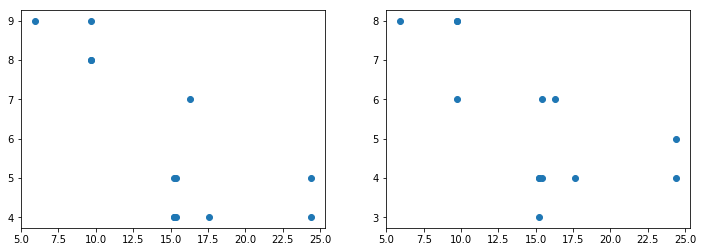

In [751]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(df_jack['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people'],
            df_jack['gsRating'])

ax2.scatter(df_jack['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people'],
            df_jack['low_income'])

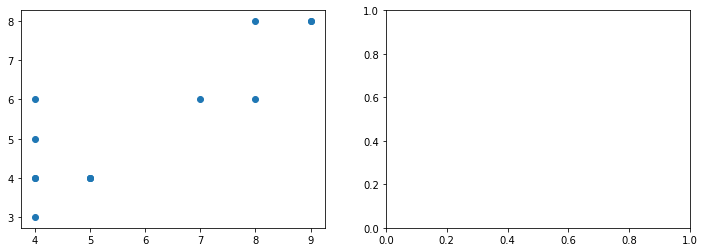

In [752]:
# Are schools that are good with low income ratings, generally good schools overall?
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(df_jack['gsRating'],
            df_jack['low_income'])

### Make a fit with one variable

In [753]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [754]:
X = df_jack['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people'].copy().values.reshape(-1,1)
y = df_jack['low_income'].copy().values.reshape(-1,1)

In [755]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.4)

In [756]:
reg_model = LinearRegression()

In [757]:
reg_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [758]:
print('intercept: ', reg_model.intercept_)
print('coefficients: ', reg_model.coef_)

intercept:  [8.78168306]
coefficients:  [[-0.22354078]]


In [759]:
pred = reg_model.predict(X_test)
pred

array([[5.38386327],
       [4.84736541],
       [5.13796842],
       [3.32728814],
       [7.46279249],
       [6.61333754]])

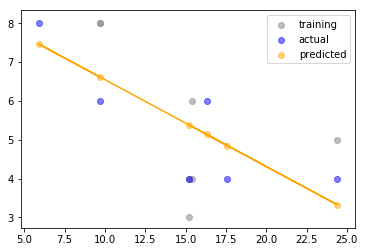

In [765]:
f, ax1 = plt.subplots()
ax1.scatter(X_train, y_train, alpha=0.5, color='gray', label='training')
ax1.scatter(X_test, y_test, color='blue', alpha=0.5, label='actual')
ax1.scatter(X_test, pred, alpha=0.5, color='orange', label='predicted')
ax1.plot(X_test, pred, color='orange')
ax1.legend();

In [766]:
print('mean absolute error: ', metrics.mean_absolute_error(y_test, pred))
print('mean squared error: ', metrics.mean_squared_error(y_test, pred))

mean absolute error:  0.819419529920427
mean squared error:  0.7489200406226537


#### Two variables

In [767]:
X = df_jack[['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people',
             '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone']].copy()
y = df_jack['low_income'].copy()

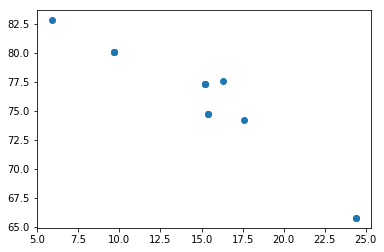

In [768]:
# Do variables correlate with each other - they do
f, ax1 = plt.subplots()
ax1.scatter(X.iloc[:,0], X.iloc[:,1])

In [646]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [647]:
reg = LinearRegression()
reg.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [648]:
print('coefficients: ', reg.coef_)
print('intercept: ', reg.intercept_)

coefficients:  [-0.51951598 -0.31809233]
intercept:  37.66423266665447


In [649]:
y_pred = reg.predict(X_test)

In [650]:
print('mean absolute error: ', metrics.mean_absolute_error(y_test, y_pred))
print('mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('square root of mean squared: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

mean absolute error:  0.7968321331043349
mean squared error:  0.8356701375354149
square root of mean squared:  0.9141499535280931


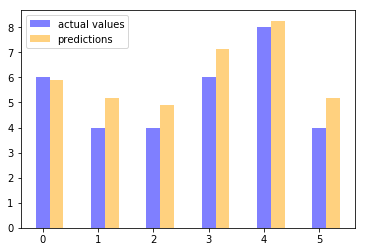

In [651]:
f, ax1 = plt.subplots()

ax1.bar(range(len(X_test)), y_test,
        width=0.25, label='actual values', color='blue', alpha=0.5)
ax1.bar([i+0.25 for i in range(len(X_test))], y_pred,
        width=0.25, label='predictions', color='orange', alpha=0.5)
ax1.legend()

#### Three variables

In [661]:
X = df_jack[['%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people',
             '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone',
            '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage']].copy()
y = df_jack['low_income'].copy()

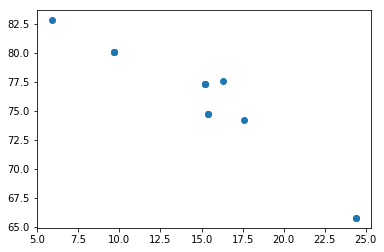

In [662]:
# Observe correlation
f, ax1 = plt.subplots()
ax1.scatter(X.iloc[:, 0], X.iloc[:, 1]);

In [663]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.4)

In [664]:
reg = LinearRegression()
reg.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [665]:
print('coefficients: ', reg.coef_)
print('intercept: ', reg.intercept_)

coefficients:  [-0.87212981 -0.82019713  0.17717351]
intercept:  65.73499750978463


In [666]:
y_pred = reg.predict(X_test)

<BarContainer object of 6 artists>

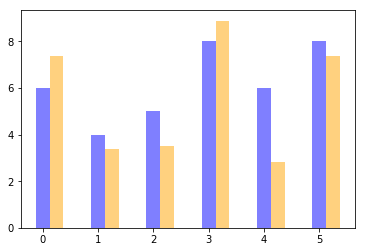

In [667]:
f, ax1 = plt.subplots()
ax1.bar(range(len(X_test)), y_test,
        width=0.25, color='blue', alpha=0.5)
ax1.bar([i+0.25 for i in range(len(X_test))], y_pred,
         width=0.25, color='orange', alpha=0.5)

In [668]:
print('mean absolute error: ', metrics.mean_absolute_error(y_test, y_pred))
print('mean squared error: ', metrics.mean_squared_error(y_test, y_pred))
print('square root of mean squared error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

mean absolute error:  1.3573370591871037
mean squared error:  2.5970929393757807
square root of mean squared error:  1.6115498563109305


In [ ]:
# Get UC/CSU eligibility

#### Using all pct features



In [669]:
X = df_jack.loc[:, df_jack.columns.str.startswith('%')].copy()
y = df_jack['low_income'].copy()

In [670]:
df_jack.loc[:, ['zip_code', 'School']]

,zip_code,School
12978,91913,Olympian High
12987,91913,Bonita Vista Senior High
12998,91913,Otay Ranch Senior High
12984,92154,Southwest Senior High
12997,92154,San Ysidro High
13005,92154,Montgomery Senior High
12988,91911,Castle Park Senior High
12990,91911,Chula Vista Senior High
12989,91915,Eastlake High
13000,91910,Hilltop Senior High


In [622]:
X

,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force,%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed,...,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Married couple families - w/ related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All people,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under 18 yrs - Related children of the householder <18 yrs - Related children of the householder 5 to 17 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18-64 yrs,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - People in families,%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs and up - Unrelated individuals 15 yrs and up
12978,70.3,67.2,63.1,4.1,3.1,29.7,6.1,62.3,61.5,58.4,...,5.9,9.7,14.3,14.3,16.7,7.7,7.3,11.0,8.2,24.7
12987,70.3,67.2,63.1,4.1,3.1,29.7,6.1,62.3,61.5,58.4,...,5.9,9.7,14.3,14.3,16.7,7.7,7.3,11.0,8.2,24.7
12998,70.3,67.2,63.1,4.1,3.1,29.7,6.1,62.3,61.5,58.4,...,5.9,9.7,14.3,14.3,16.7,7.7,7.3,11.0,8.2,24.7
12984,60.5,59.1,51.7,7.4,1.4,39.5,12.5,57.8,57.4,51.0,...,9.1,15.2,21.4,20.9,21.3,12.9,13.2,11.4,13.3,34.2
12997,60.5,59.1,51.7,7.4,1.4,39.5,12.5,57.8,57.4,51.0,...,9.1,15.2,21.4,20.9,21.3,12.9,13.2,11.4,13.3,34.2
13005,60.5,59.1,51.7,7.4,1.4,39.5,12.5,57.8,57.4,51.0,...,9.1,15.2,21.4,20.9,21.3,12.9,13.2,11.4,13.3,34.2
12988,62.1,61.7,53.1,8.6,0.4,37.9,13.9,56.0,56.0,47.9,...,9.1,15.4,21.2,20.8,19.8,13.5,14.1,10.6,13.1,31.9
12990,62.1,61.7,53.1,8.6,0.4,37.9,13.9,56.0,56.0,47.9,...,9.1,15.4,21.2,20.8,19.8,13.5,14.1,10.6,13.1,31.9
12989,68.2,64.8,60.0,4.9,3.4,31.8,7.5,60.5,59.6,54.7,...,2.8,5.9,6.3,6.3,6.7,5.7,5.5,7.9,5.3,18.2
13000,62.2,61.3,53.9,7.4,0.9,37.8,12.0,56.5,55.9,49.6,...,12.0,16.3,24.3,24.0,22.1,13.9,14.0,13.2,14.0,28.6


## Look for other features that correlate with low income rating

In [ ]:
# Try to find number of low income students... could be statistical anomaly?

In [486]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(*args, **kwargs)
    Make a bar plot.
    
    Call signatures::
    
       bar(x, height, *, align='center', **kwargs)
       bar(x, height, width, *, align='center', **kwargs)
       bar(x, height, width, bottom, *, align='center', **kwargs)
    
    The bars are positioned at *x* with the given *align* ment. Their
    dimensions are given by *width* and *height*. The vertical baseline
    is *bottom* (default 0).
    
    Each of *x*, *height*, *width*, and *bottom* may either be a scalar
    applying to all bars, or it may be a sequence of length N providing a
    separate value for each bar.
    
    
    Parameters
    ----------
    x : sequence of scalars
        The x coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    height : scalar or sequence of scalars
        The height(s) of the bars.
    
    width : scalar or array-like, optional
        The width(s) of the